In [1]:
import os
os.environ["SPARK_HOME"] = "/home/hadoop/spark"

import findspark
findspark.init()

import pyspark
sc = pyspark.SparkContext(appName = "strawberry_avg")

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

24/06/10 18:32:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/10 18:32:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, to_date
import os

# 새로운 SparkSession 생성
spark = SparkSession.builder \
    .appName("Strawberry Data Analysis") \
    .getOrCreate()

# 파일 경로 설정
file_path = "hdfs://master01:9000/user/hadoop/strawberry.csv"

# CSV 파일 불러오기
df = spark.read.csv(file_path, header=True, inferSchema=True)

# 날짜 부분만 추출
df_with_date = df.withColumn("date", to_date(col("STRG_DT"), "yyyy-MM-dd"))

# 열 이름 수집 (MSRM_DT와 date를 제외한 열들)
columns = [col for col in df.columns if col != "STRG_DT"]

# 날짜별 그룹화하여 평균 계산 (null 값을 제외하고 평균 계산)
agg_exprs = [F.mean(col).alias(col) for col in columns]

# 날짜별 그룹화 및 평균 계산
average_df = df_with_date.groupBy("date").agg(*agg_exprs)
average_df_sorted = average_df.orderBy("date")

# 절대 경로로 저장 경로 설정
output_path = "/home/hadoop"

# 통합된 데이터 저장
output_file = os.path.join(output_path, "daily_avg_strawberry_data.csv")
average_df_sorted.coalesce(1).write.csv(output_file, header=True, mode='overwrite')

24/06/07 01:13:43 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


In [5]:
import pandas as pd

# 파일 경로 설정
file_path = "/home/hadoop/strawberry_avg.csv"

# pandas를 사용하여 CSV 파일 불러오기
df = pd.read_csv(file_path)

# 상위 5개 행 출력
df.head()

date  INNER_TPRT_3  INNER_HMDT_7  CLR_OPMD_5  CLR_OPRT_YN_1  \
0  2022-01-01           0.0           0.0         1.0            0.0   
1  2022-01-02           0.0           0.0         1.0            0.0   
2  2022-01-03           0.0           0.0         1.0            0.0   
3  2022-01-04           0.0           0.0         1.0            0.0   
4  2022-01-05           0.0           0.0         1.0            0.0   

   SUB_MHRLS_OPMD_1  VNTILAT_TPRT_1  EXTN_TPRT  CLR_OPMD_2  BLMNG_CNT  ...  \
0          0.318182       19.620344  -0.619117         1.0       1.21  ...   
1          0.318182       19.636343   0.349784         1.0       1.21  ...   
2          0.318182       19.641006   0.473136         1.0       1.21  ...   
3          0.175189       19.070462   1.219939         1.0       1.21  ...   
4          0.045455       18.172519   2.060496         1.0       1.21  ...   

   FMGEQ_OPMD  HRZNT_SCRN_OPMD_1  SPRYN_DEVICE  HTNG_TPRT_3  CLR_OPMD_4  \
0    0.277778           0.318182      0.037247          0.0         1.0   
1    0.000000           0.318182      0.038510          0.0         1.0   
2    0.000000           0.318182      0.038826          0.0         1.0   
3    0.000000           0.234364      0.041183          0.0         1.0   
4    0.000000           0.045455      0.029356          0.0         1.0   

   INNER_HMDT_6  FMGEQ_OPRT_YN  ZONE_NM  AVE_INNER_HMDT_3_4  FRT_WT_WDTH_RATE  
0           0.0       0.133207      NaN                 0.0              5.38  
1           0.0       0.199811      NaN                 0.0              5.38  
2           0.0       0.199495      NaN                 0.0              5.38  
3           0.0       0.212121      NaN                 0.0              5.38  
4           0.0       0.205808      NaN                 0.0              5.38  

[5 rows x 128 columns]

In [2]:
from pyspark.sql import SparkSession
import pandas as pd

# 새로운 SparkSession 생성
spark = SparkSession.builder \
    .appName("Gaussian Analysis") \
    .getOrCreate()

# 파일 경로 설정
file_path = "hdfs://master01:9000/user/hadoop/strawberry_avg.csv"

# CSV 파일 불러오기
df = spark.read.csv(file_path, header=True, inferSchema=True)

# 데이터프레임을 pandas 데이터프레임으로 변환
pdf = df.toPandas()

24/06/10 18:33:07 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.
/home/hadoop/spark/python/pyspark/sql/dataframe.py:2195: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


In [3]:
# 모든 값이 null인 열 확인 및 제거
pdf = pdf.dropna(axis=1, how='all')

# 각 열의 평균과 표준 편차 계산
stats = pdf.describe().transpose()
means = stats['mean']
std_devs = stats['std']

/home/hadoop/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/hadoop/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


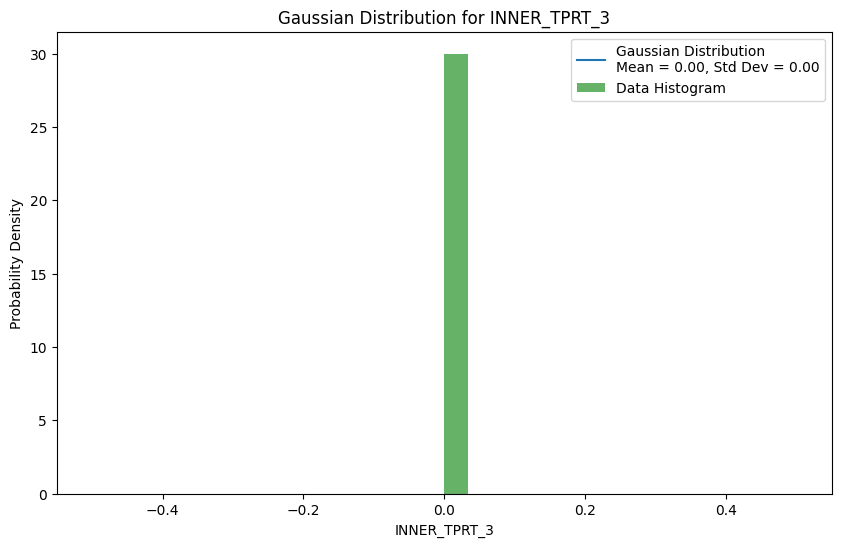

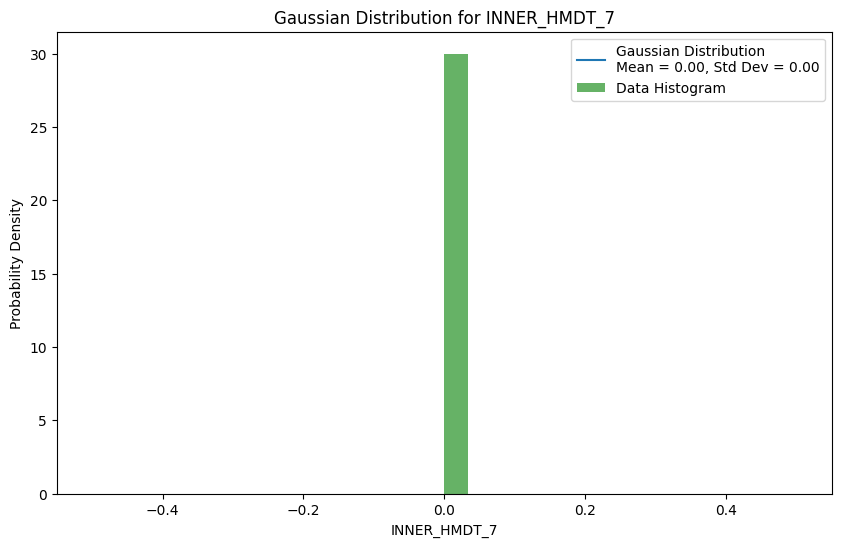

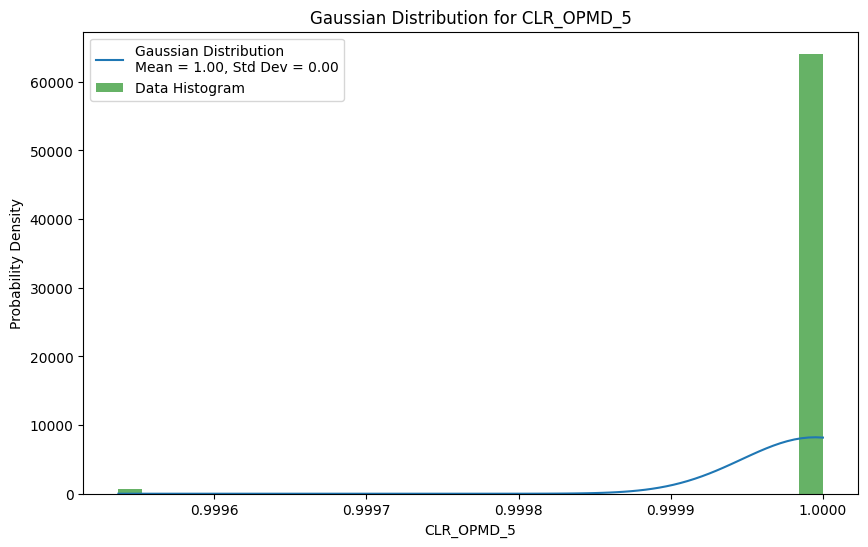

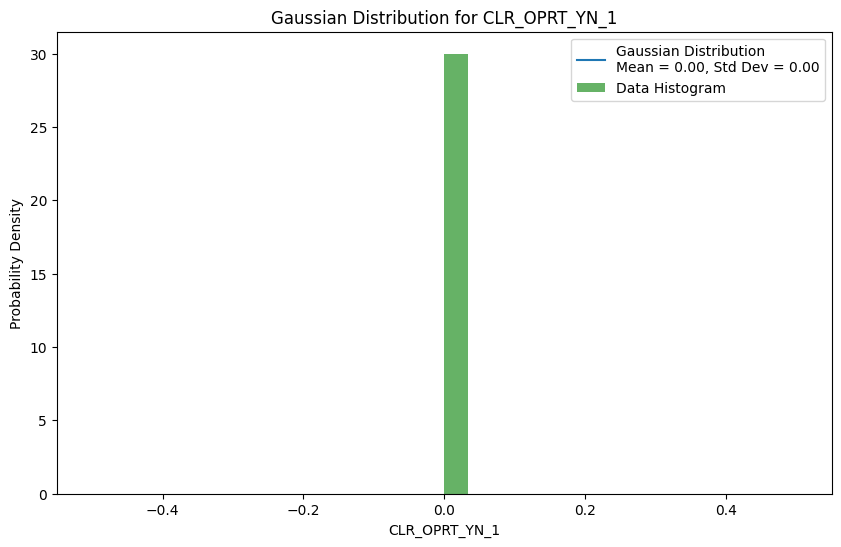

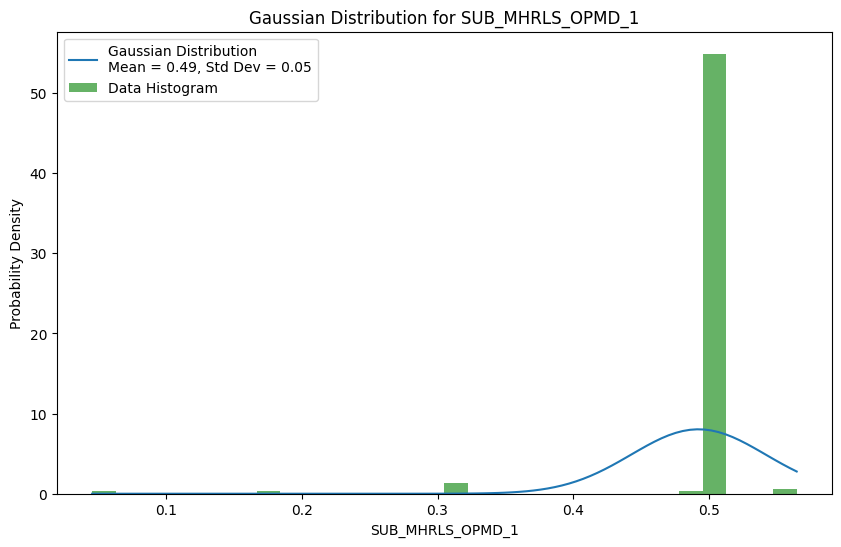

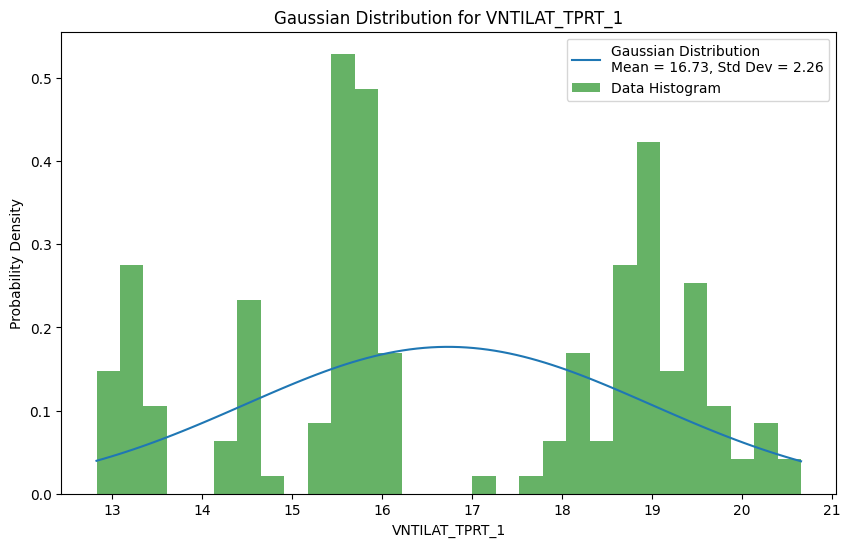

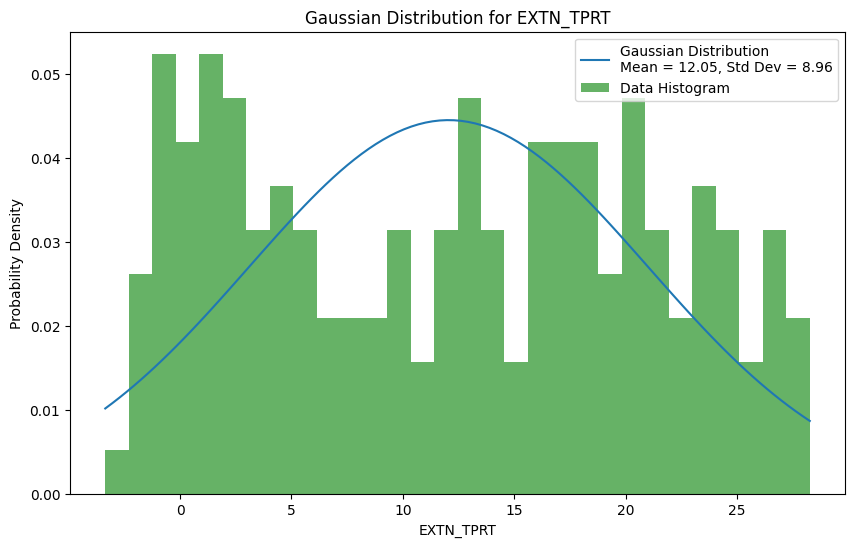

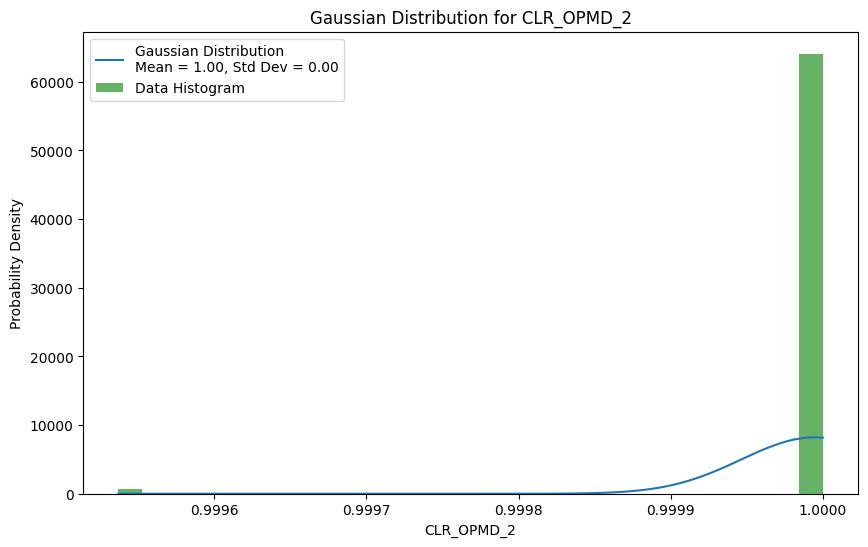

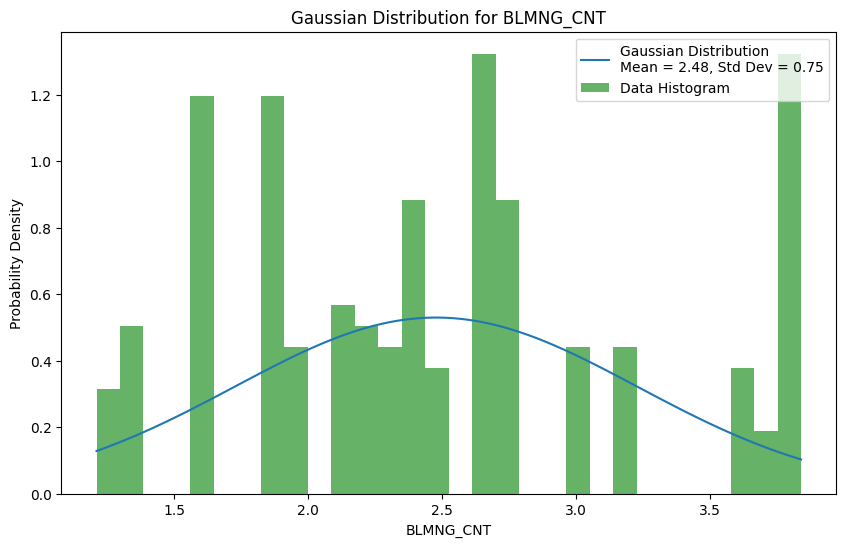

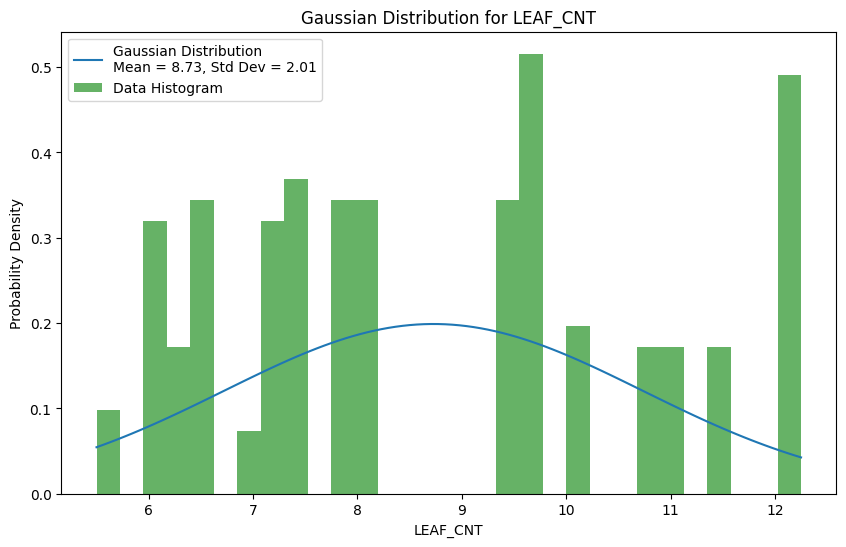

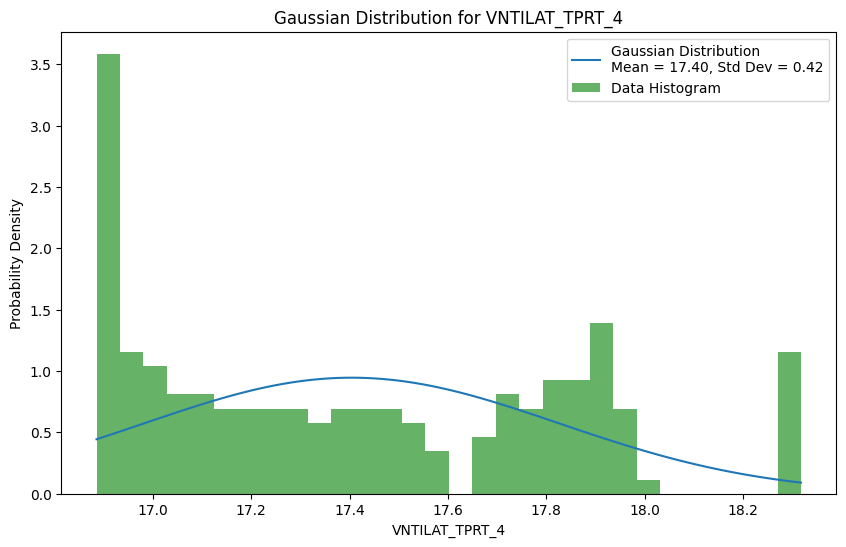

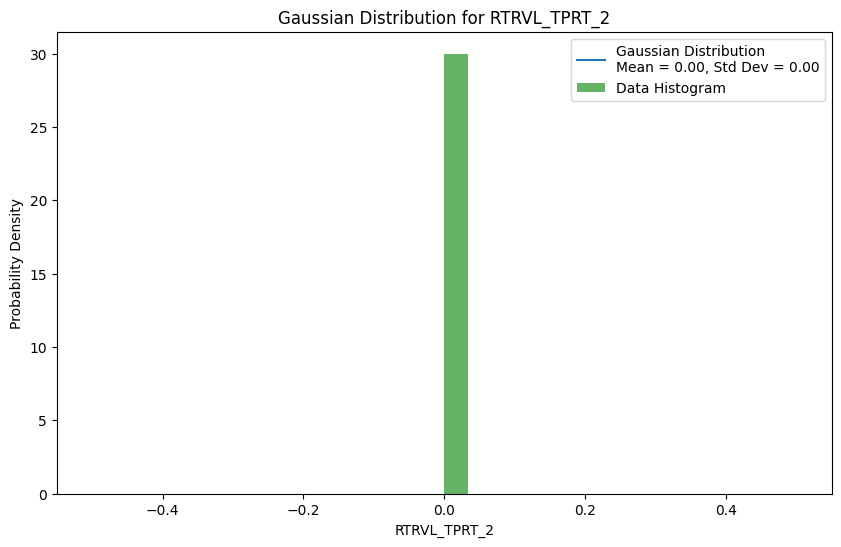

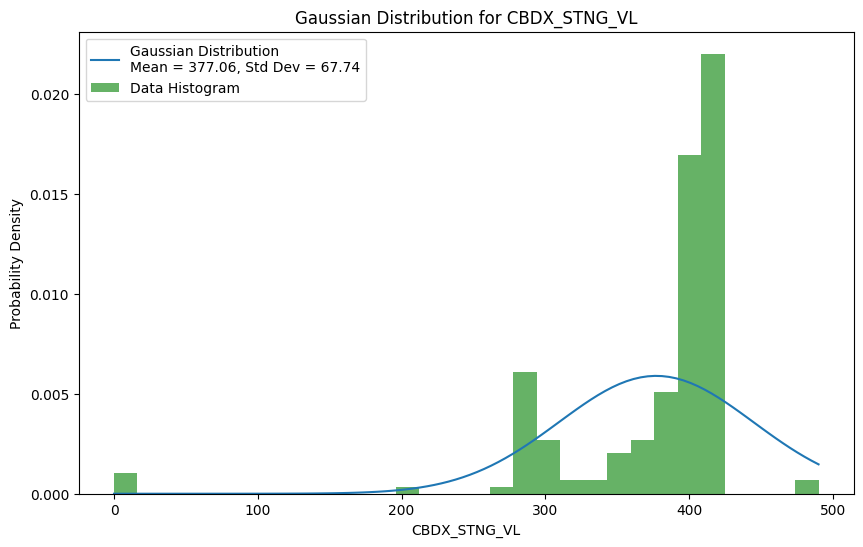

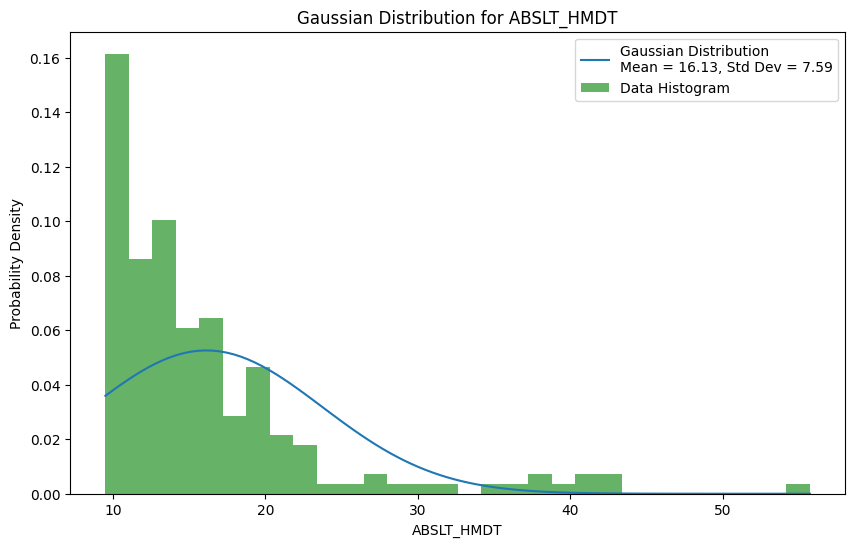

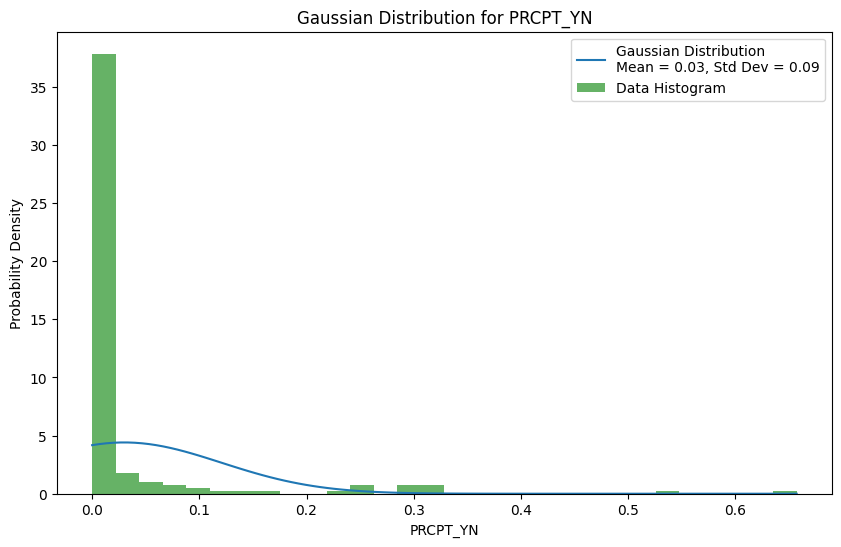

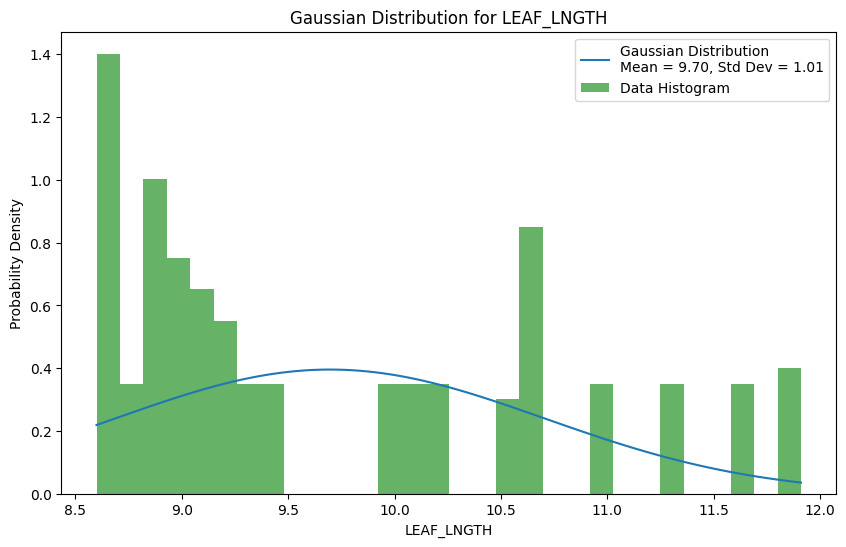

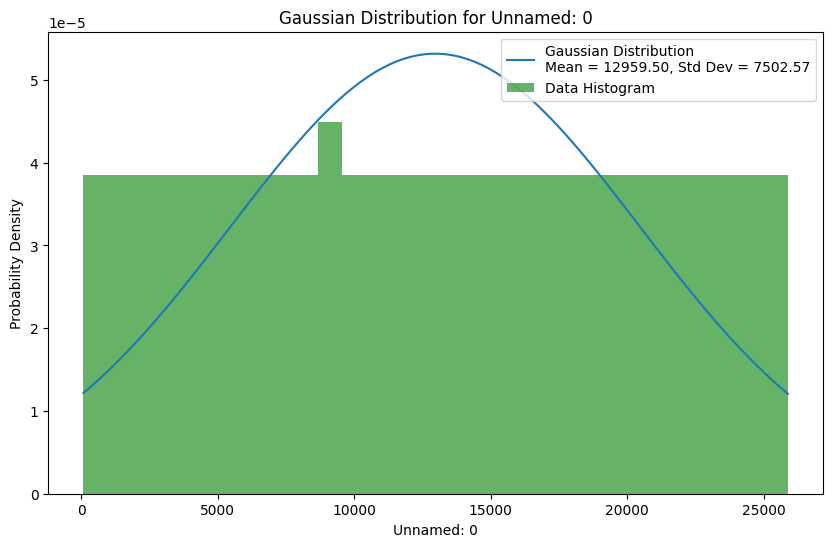

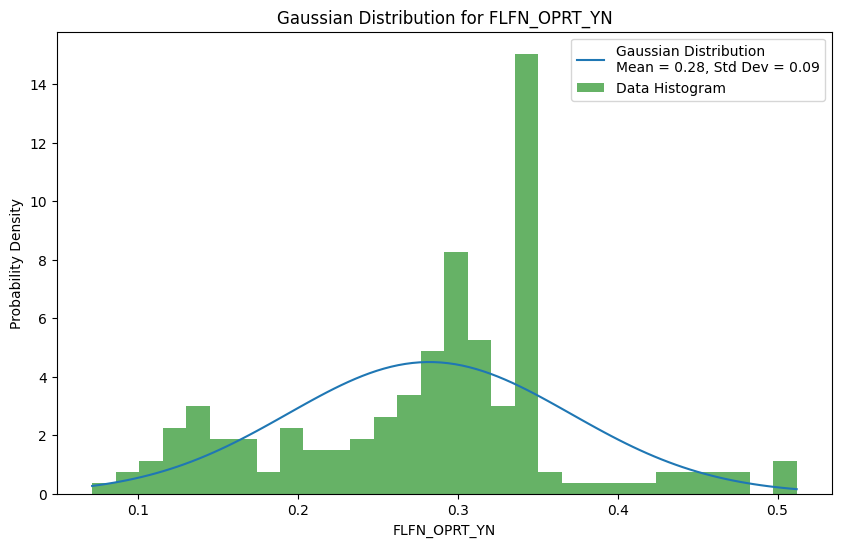

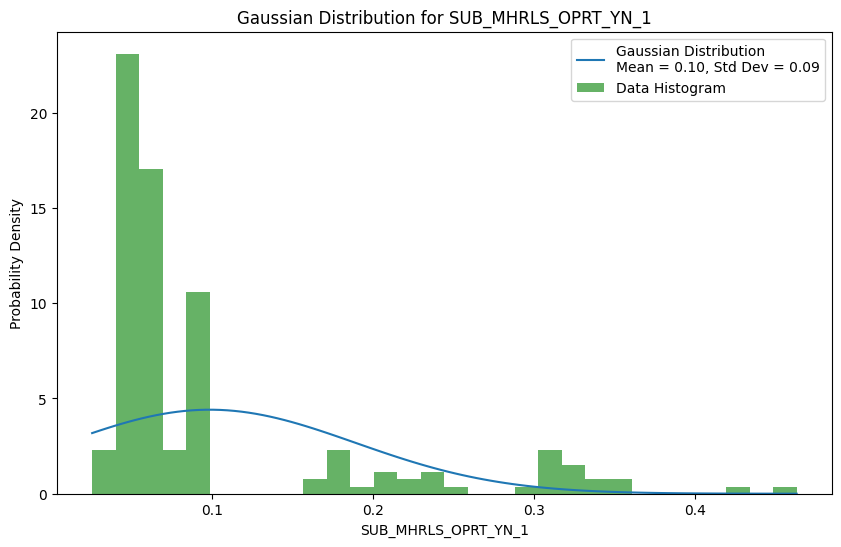

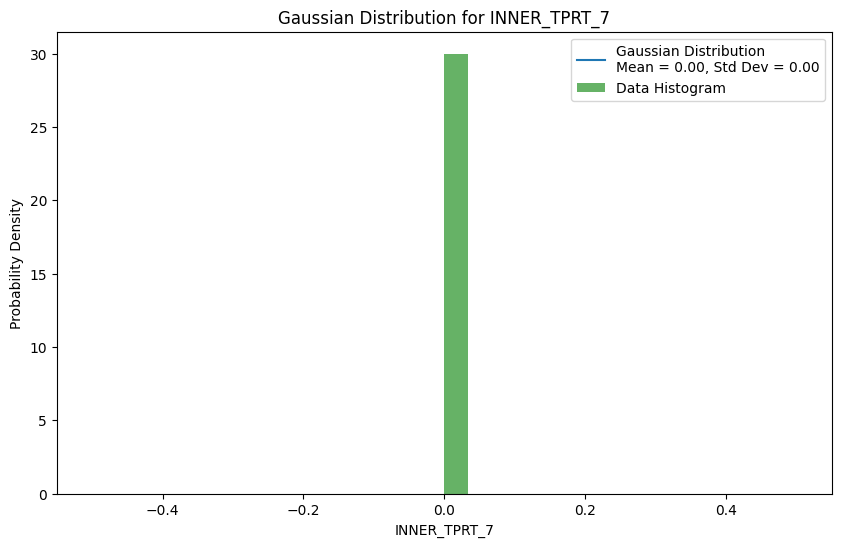

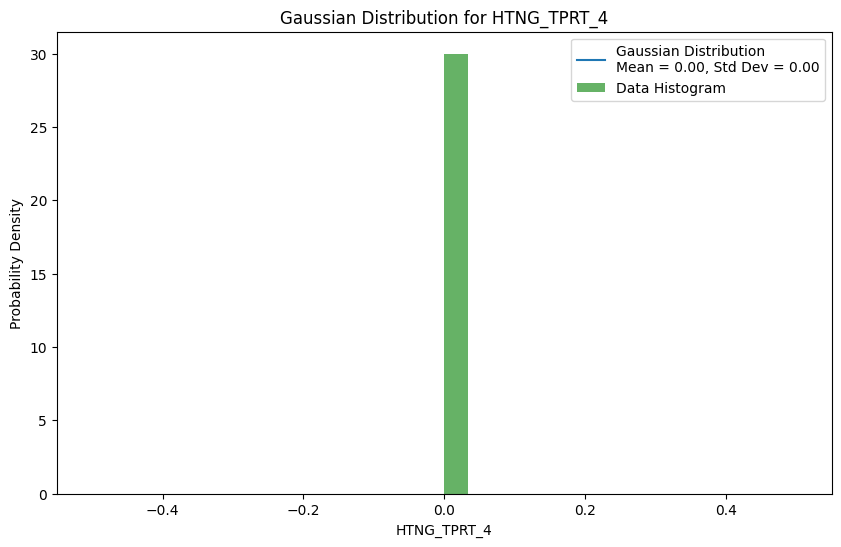

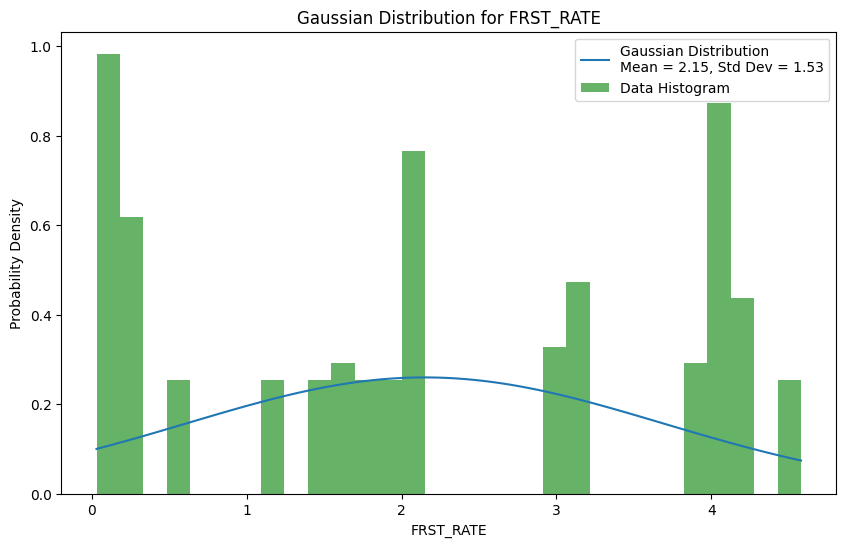

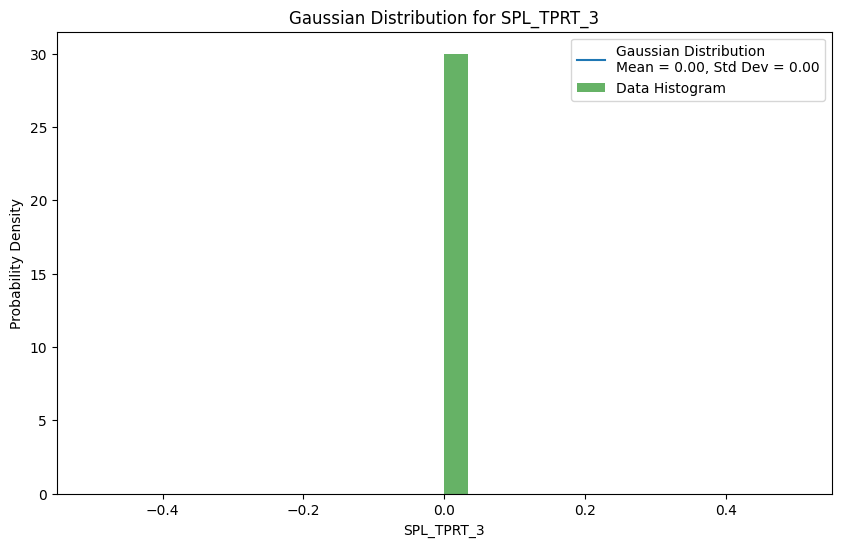

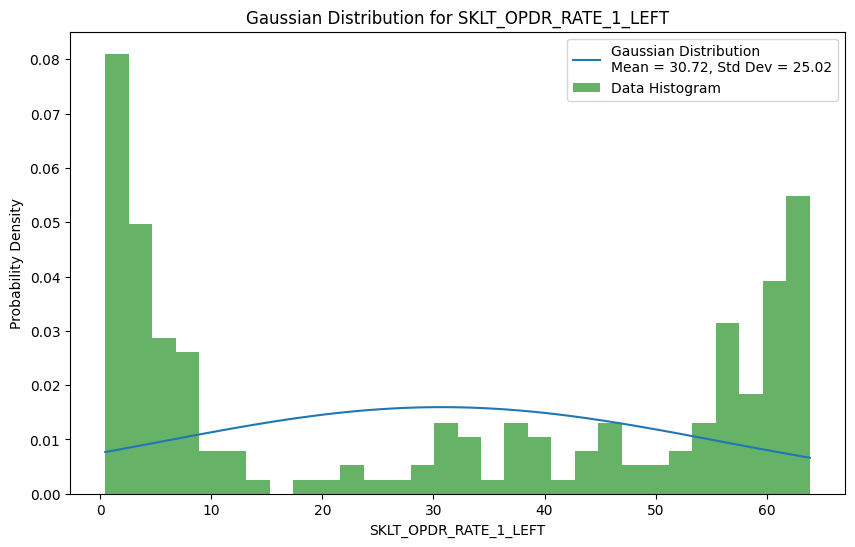

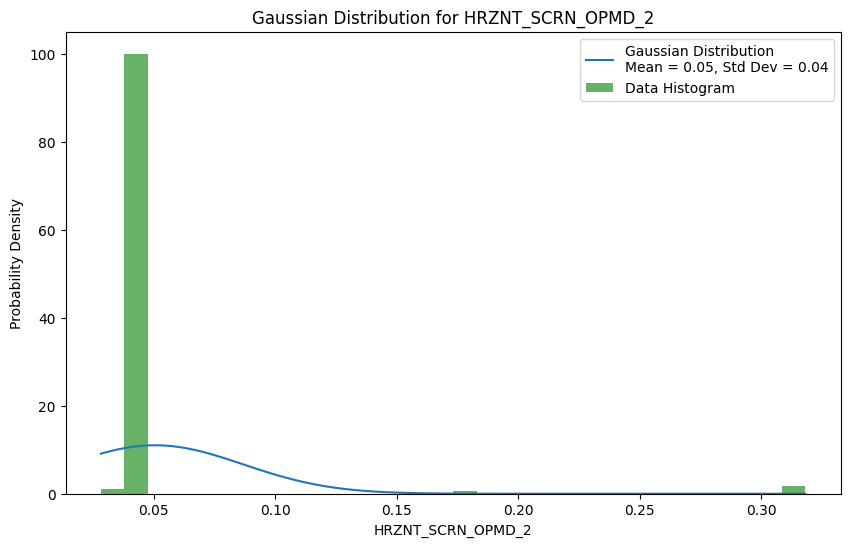

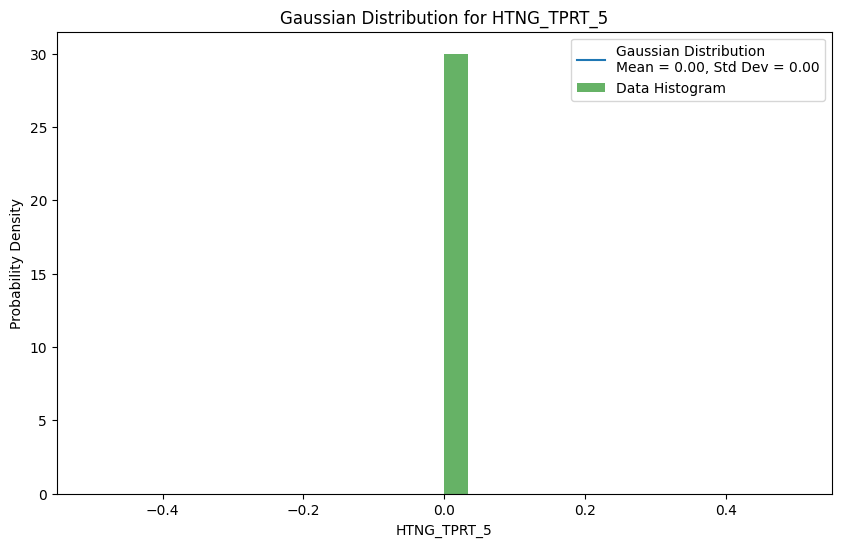

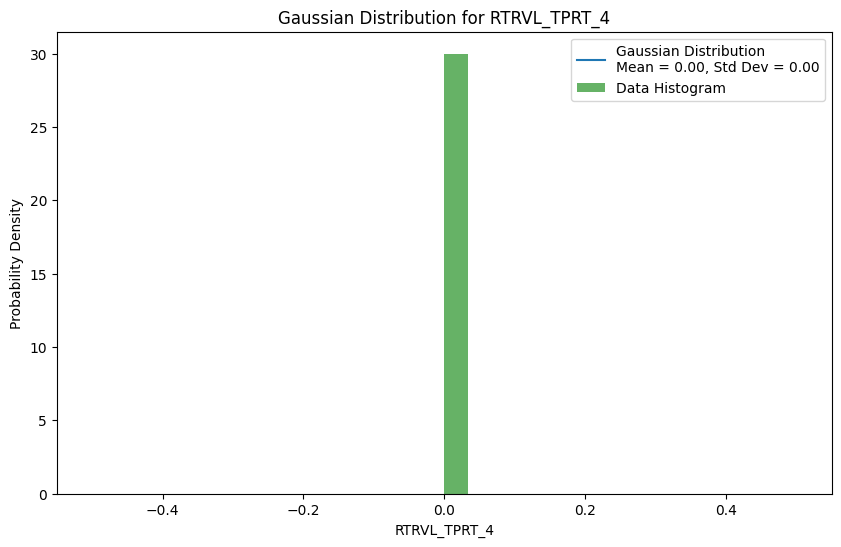

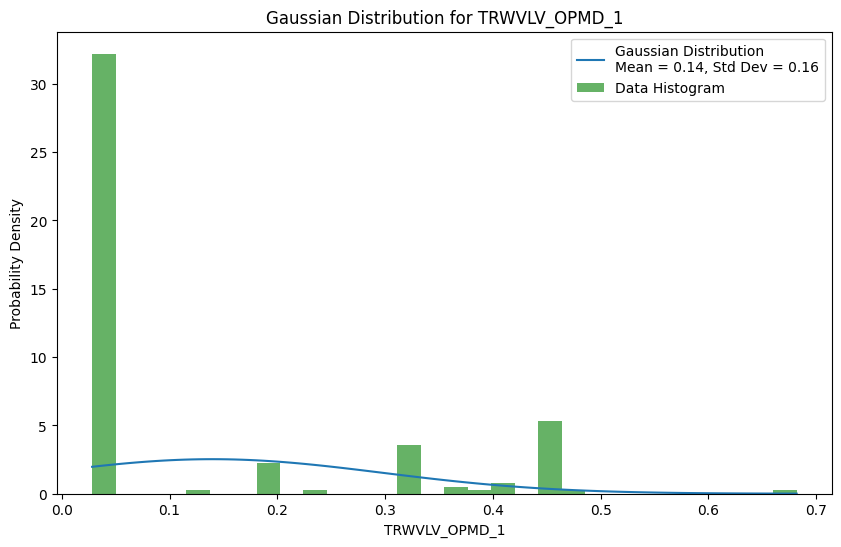

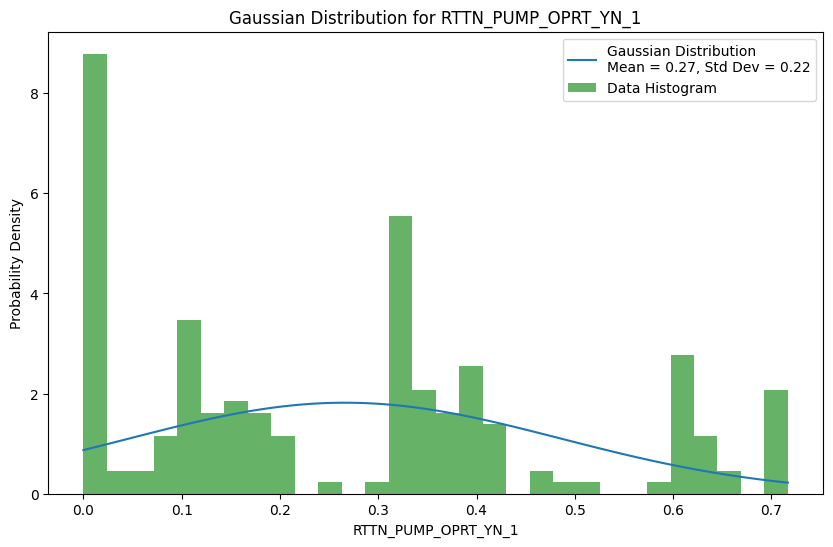

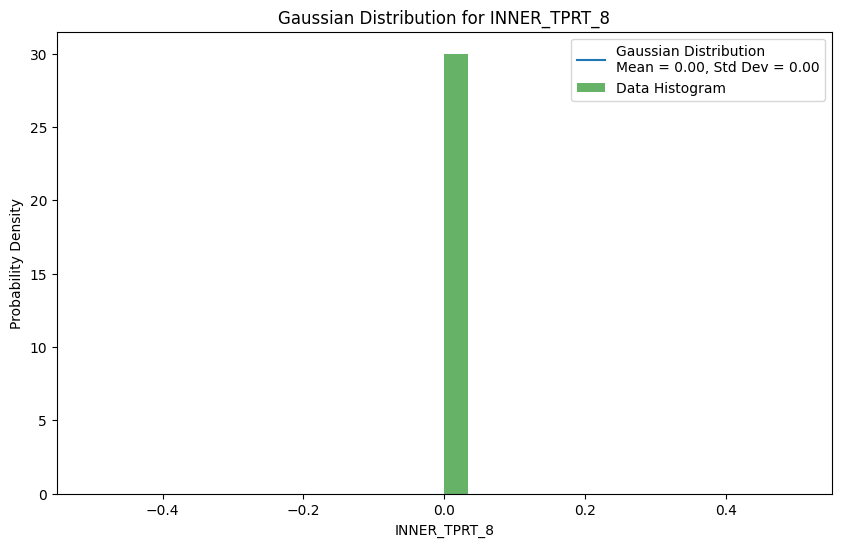

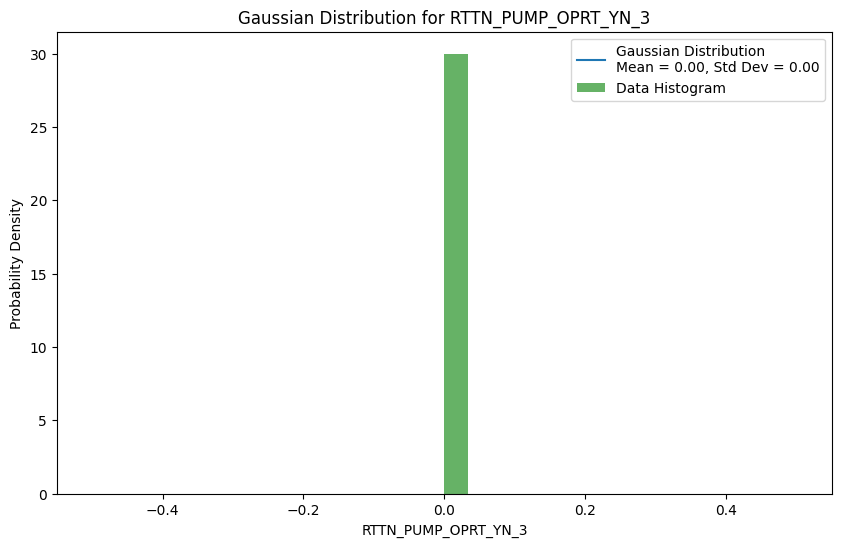

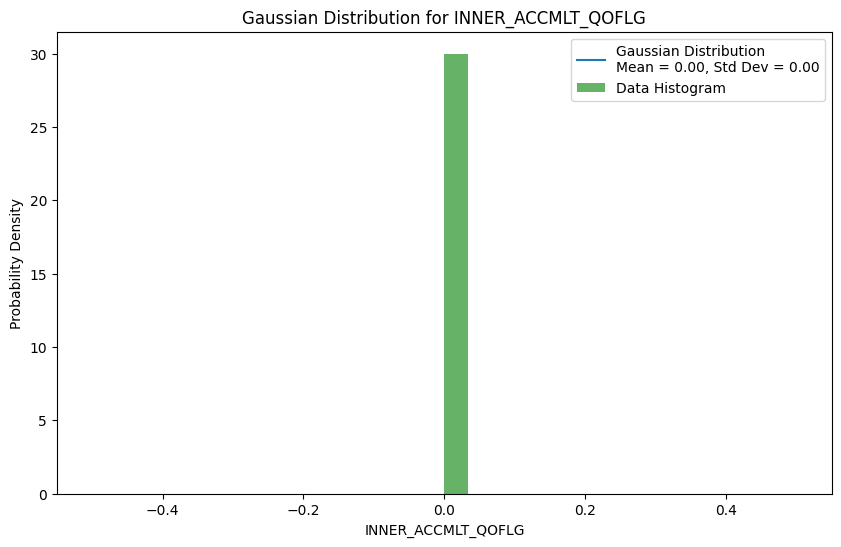

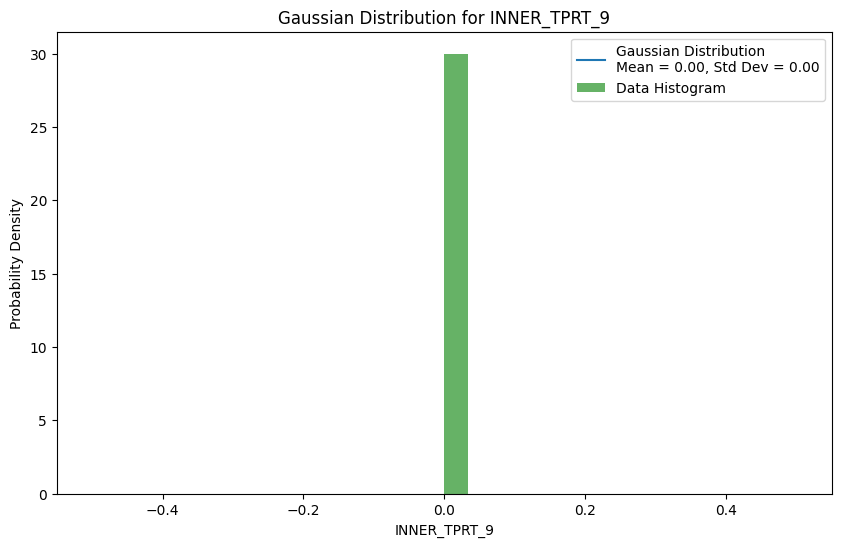

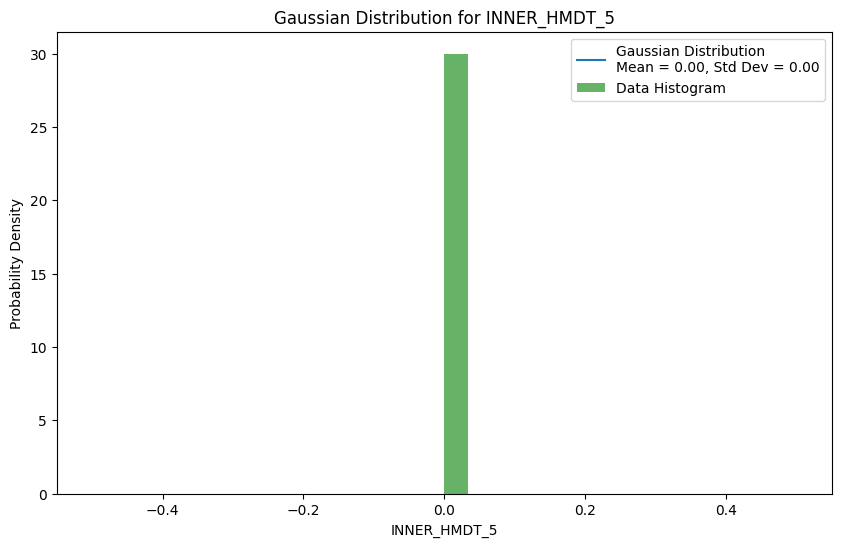

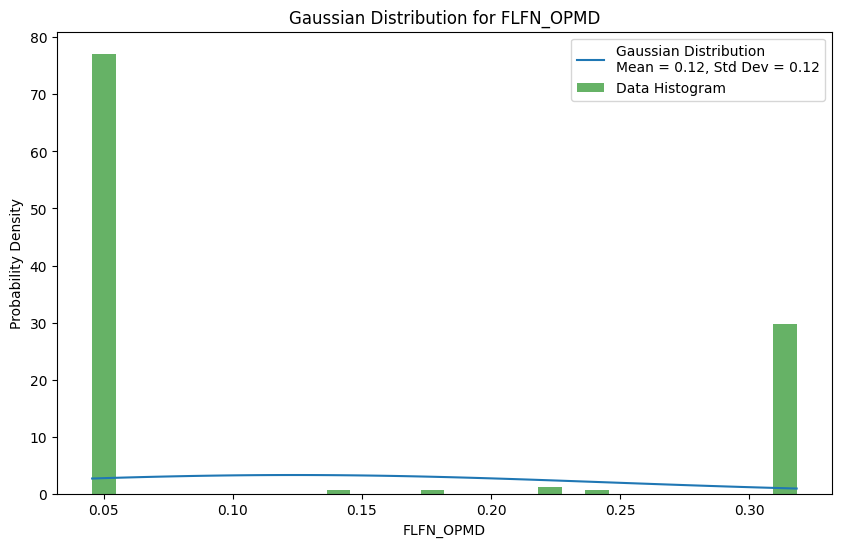

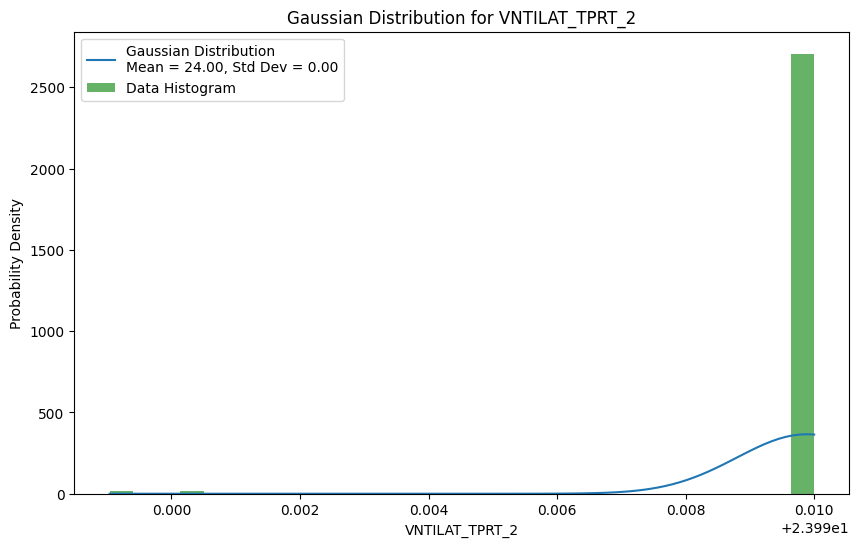

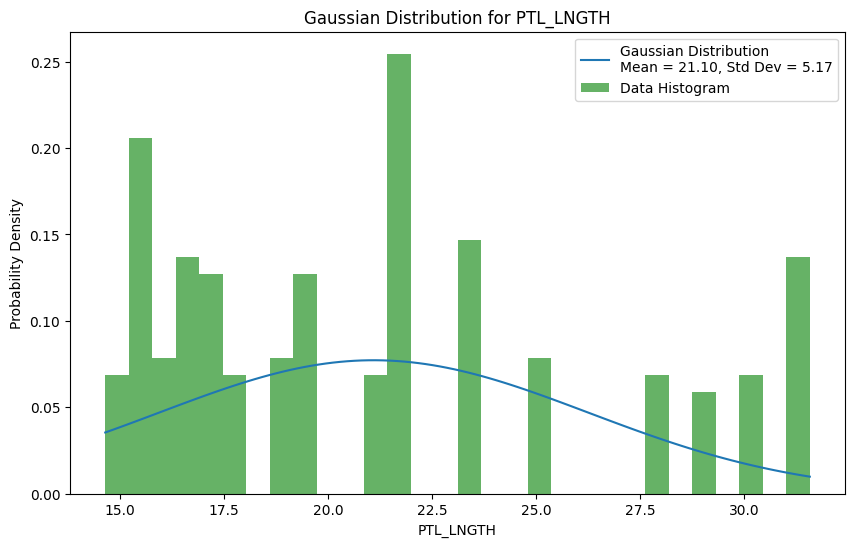

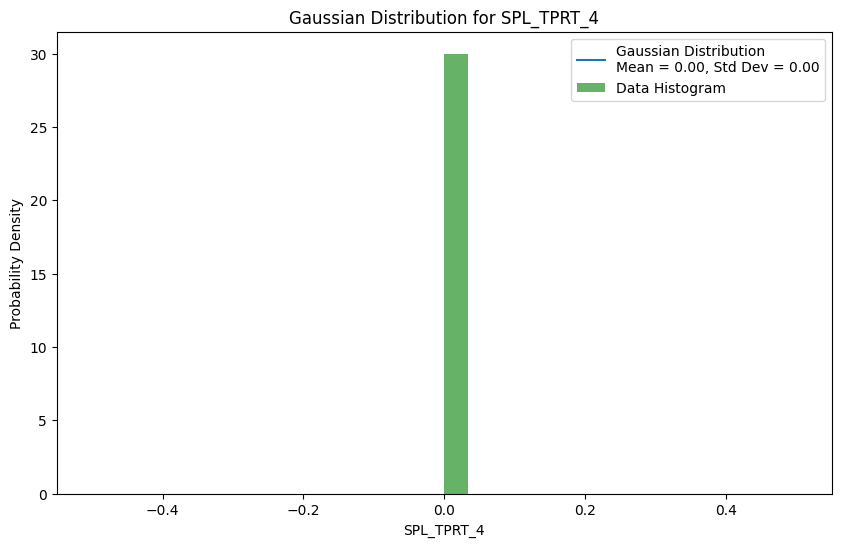

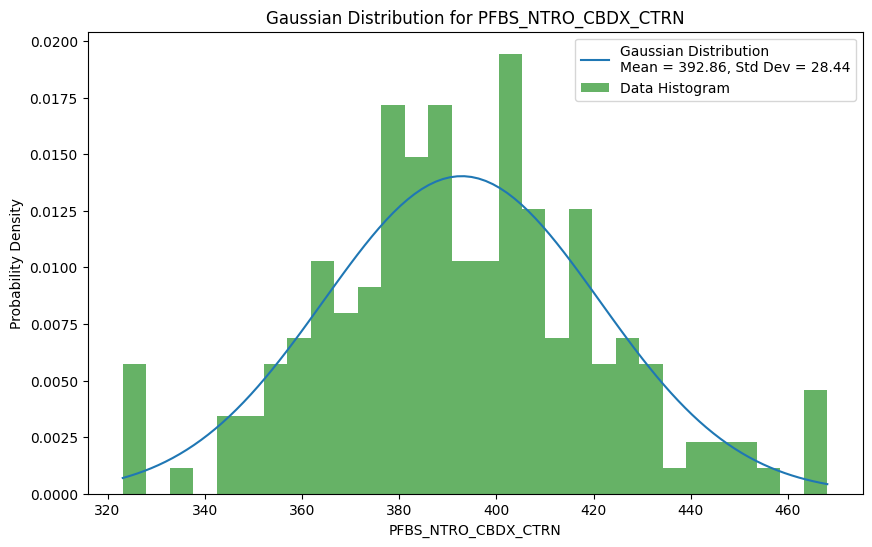

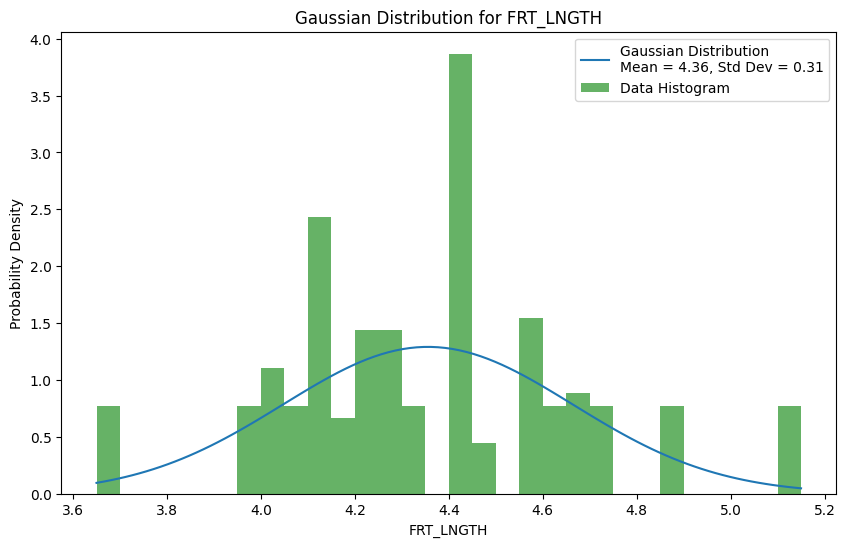

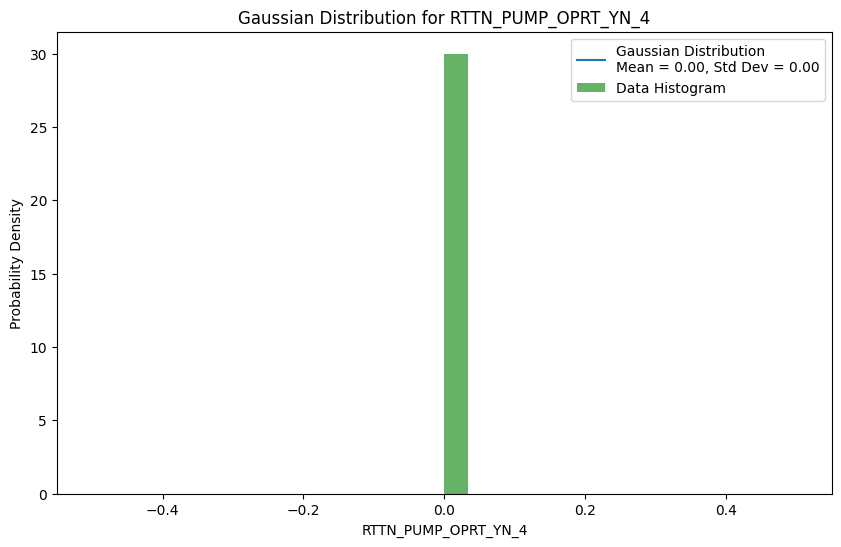

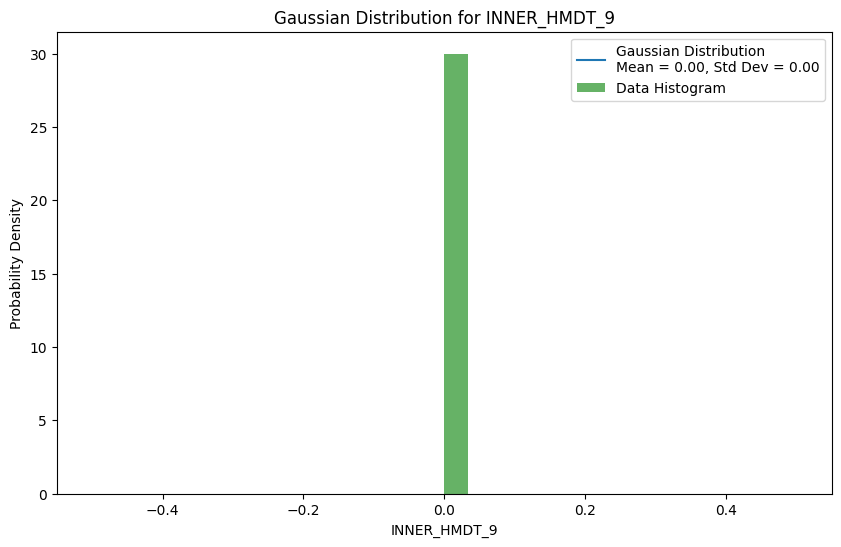

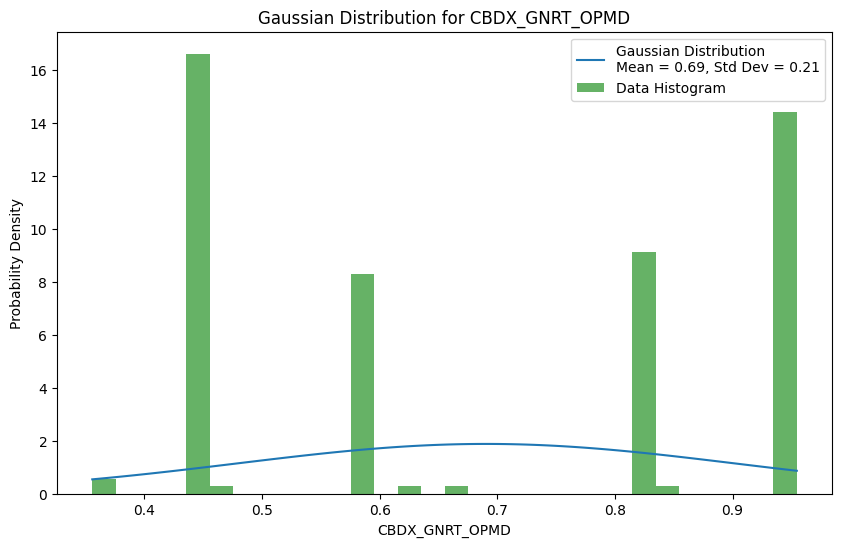

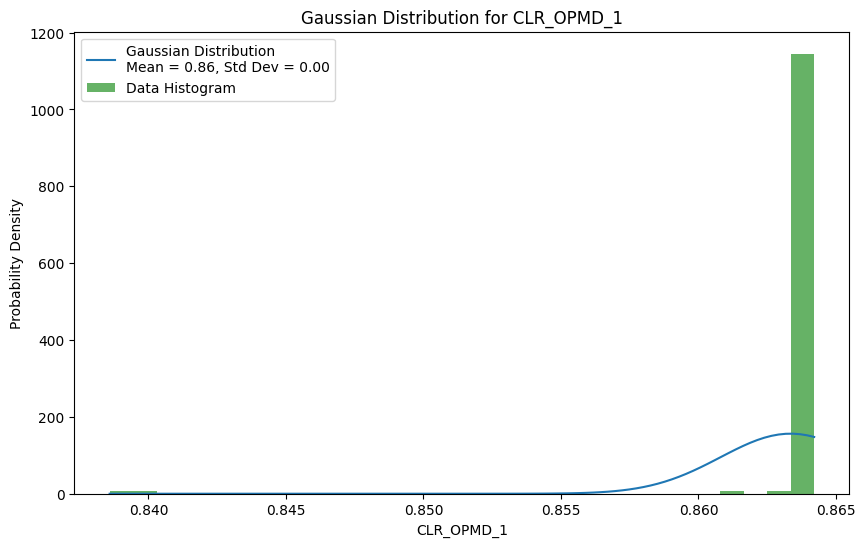

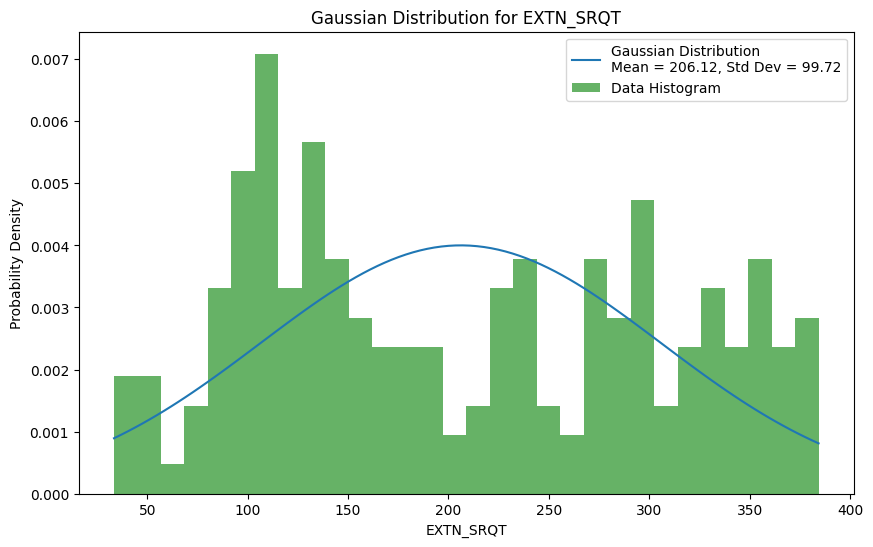

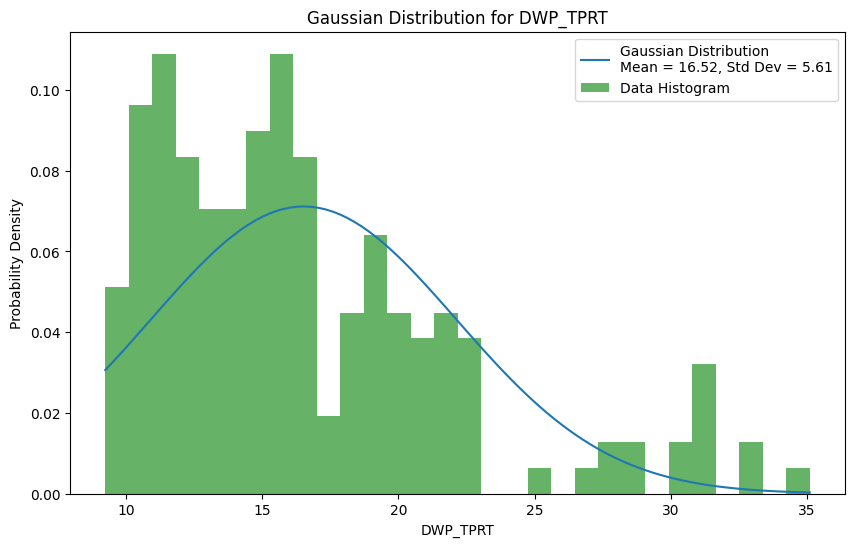

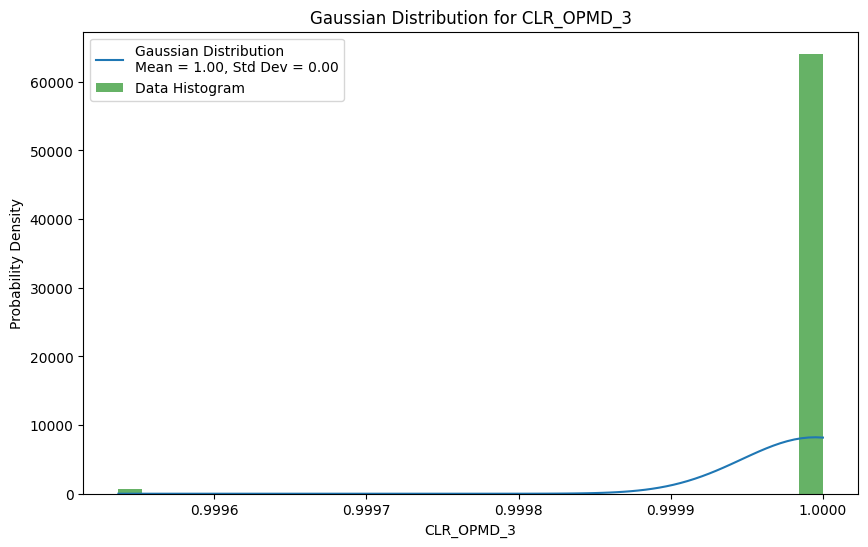

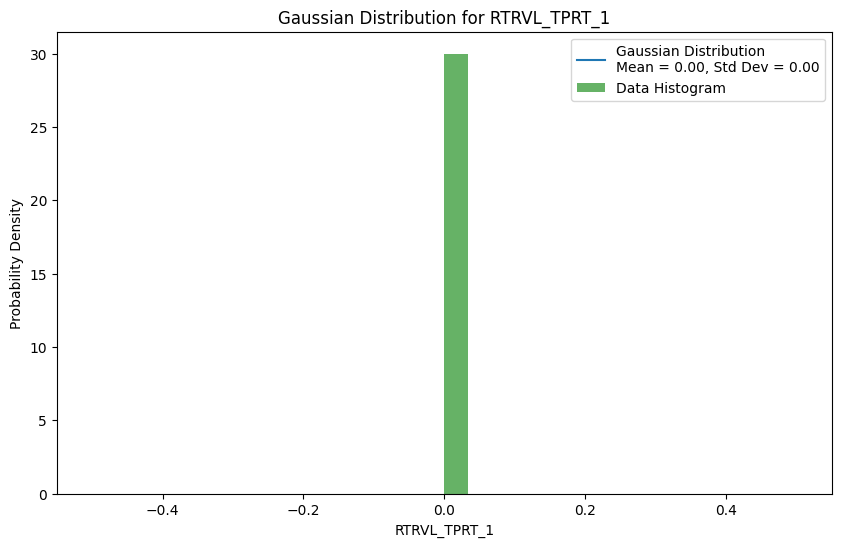

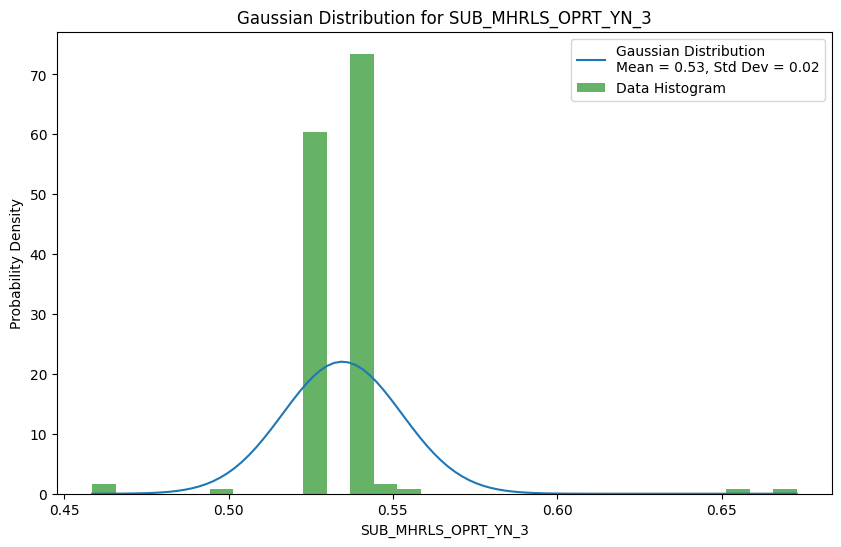

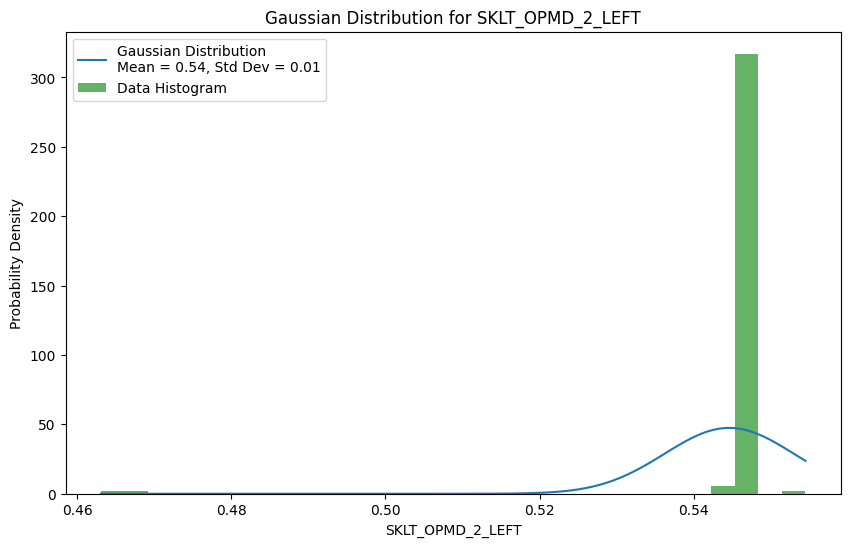

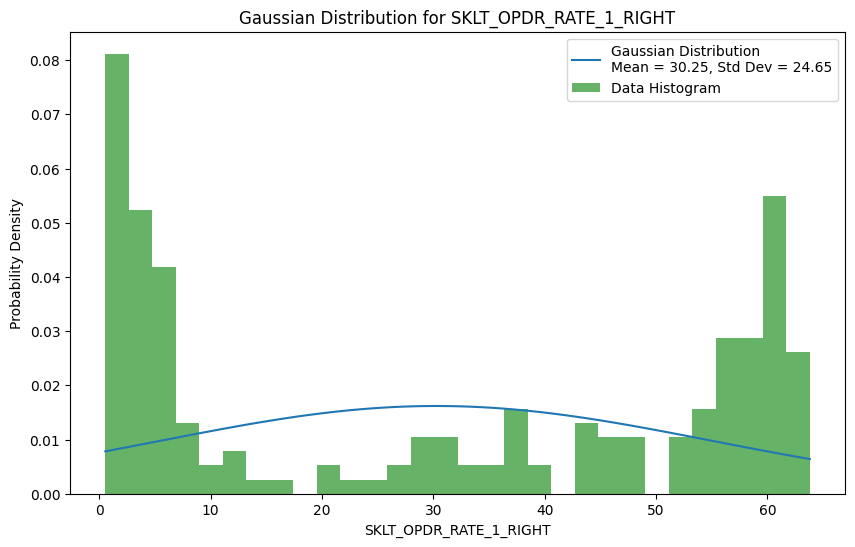

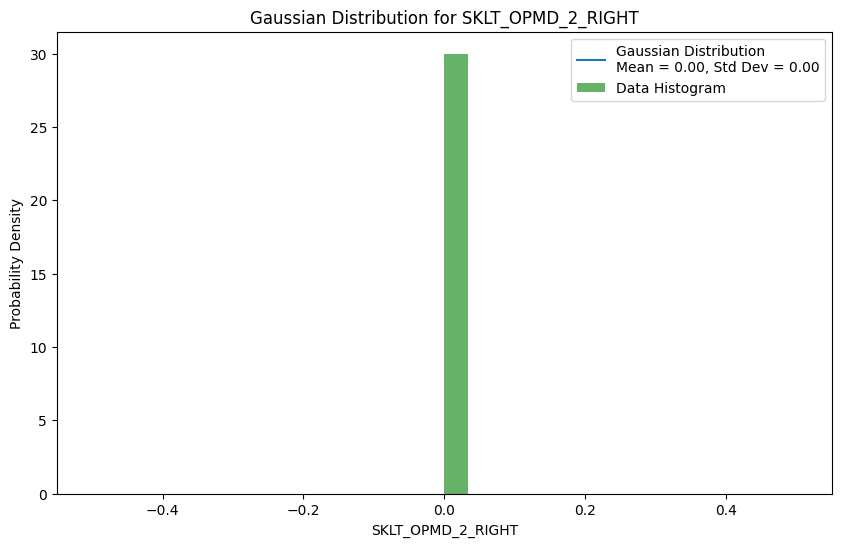

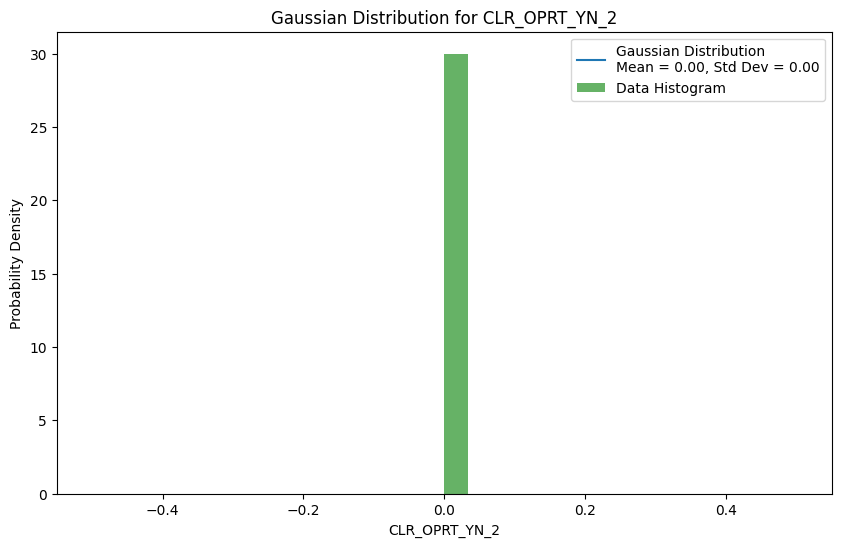

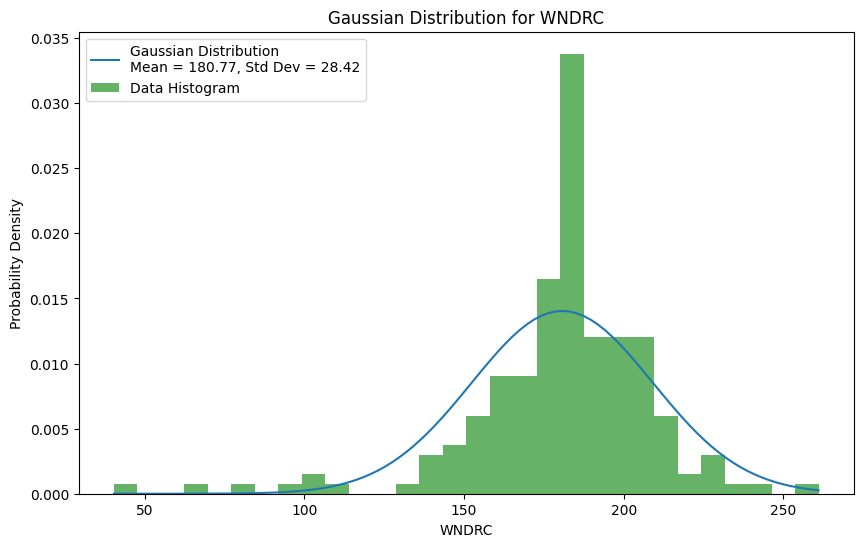

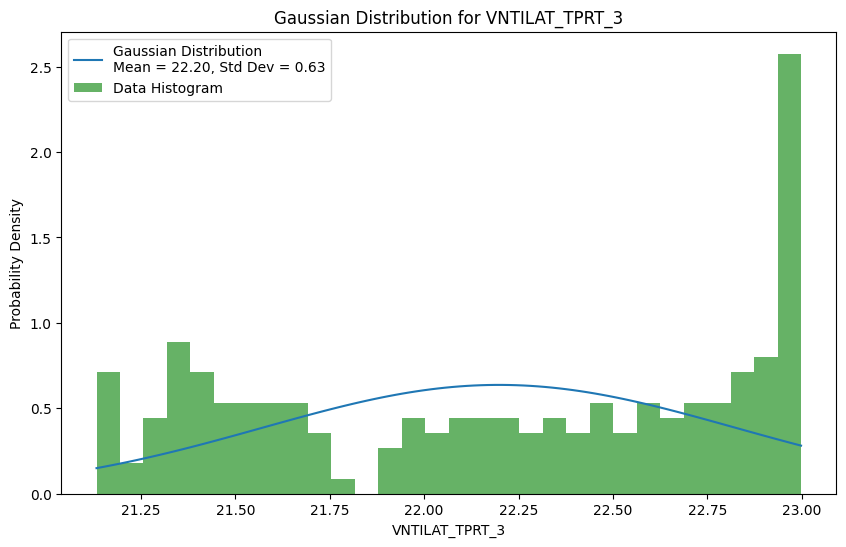

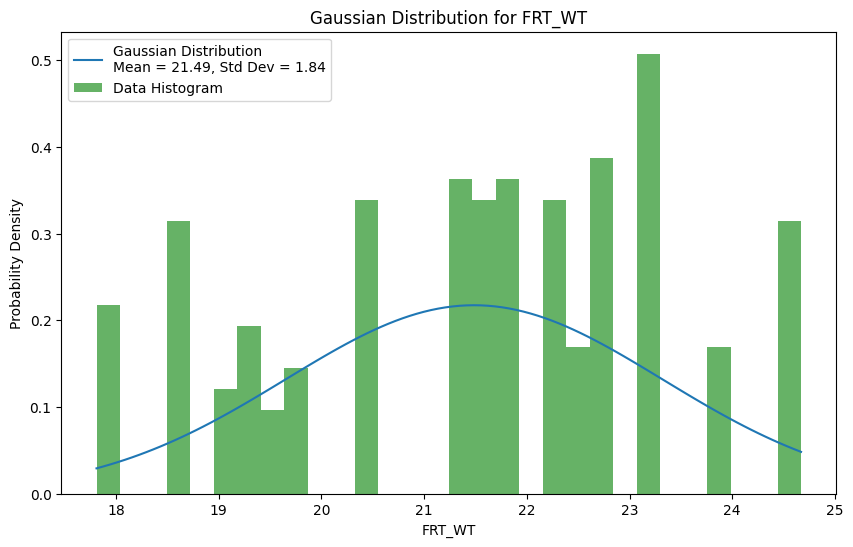

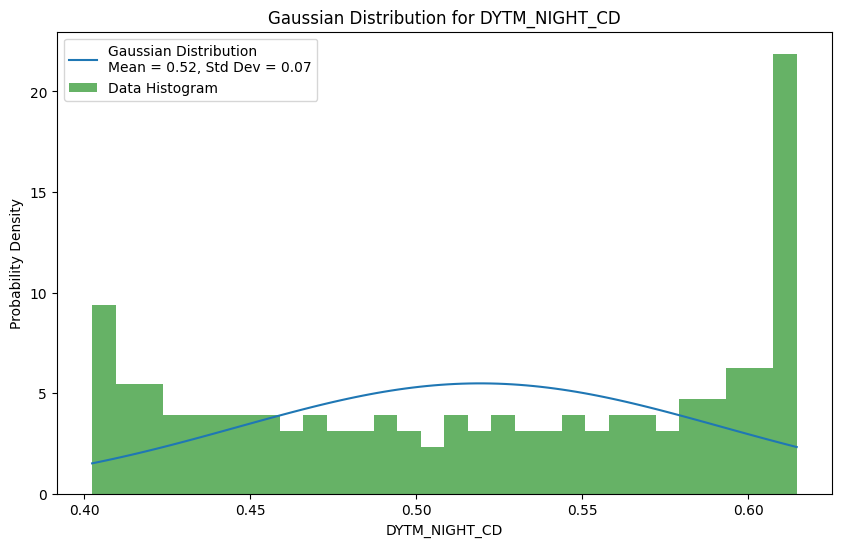

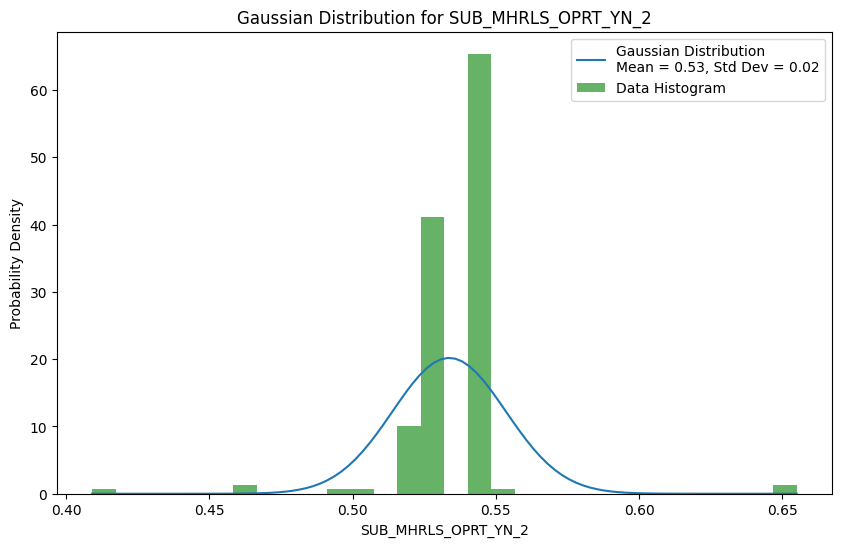

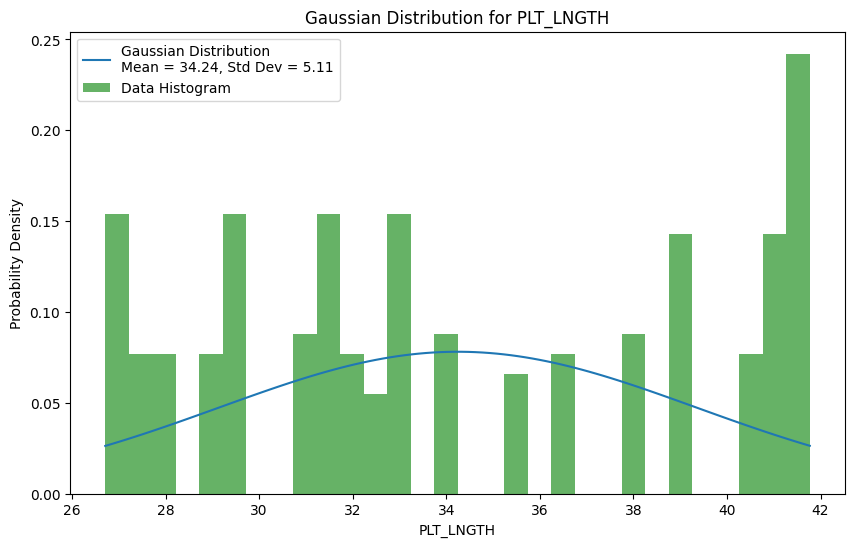

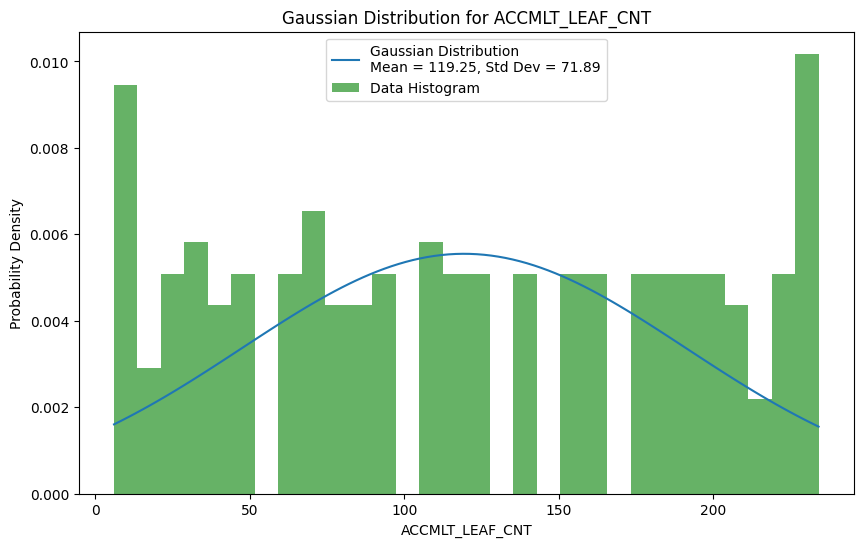

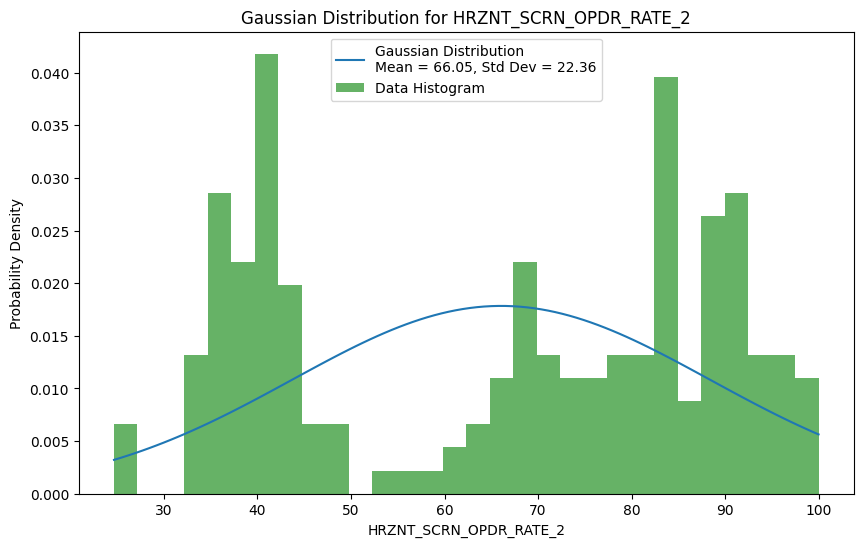

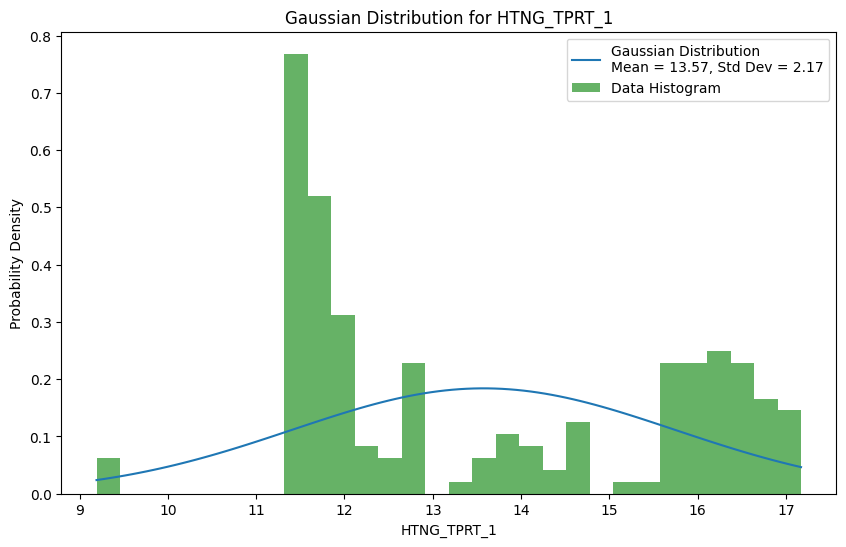

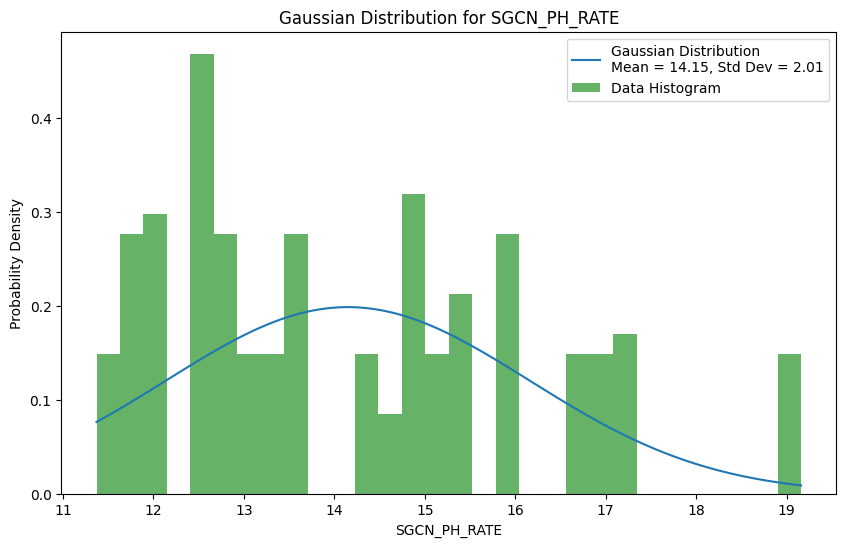

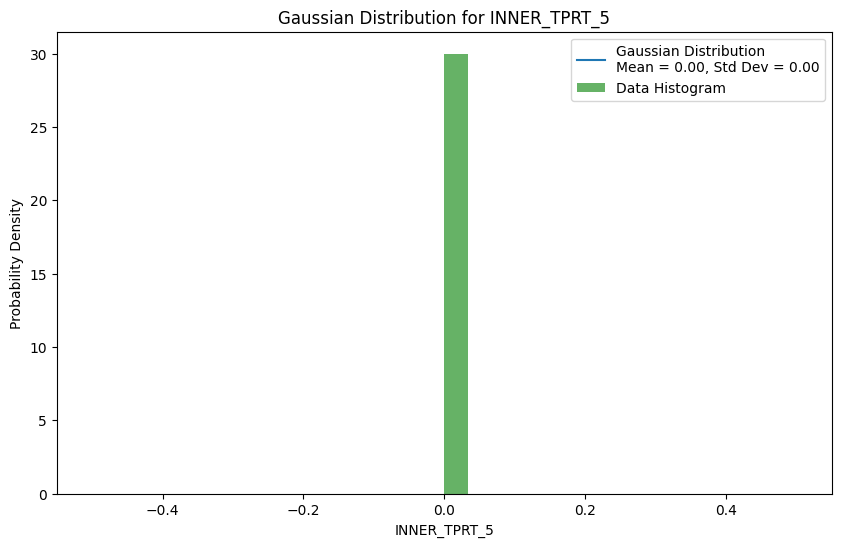

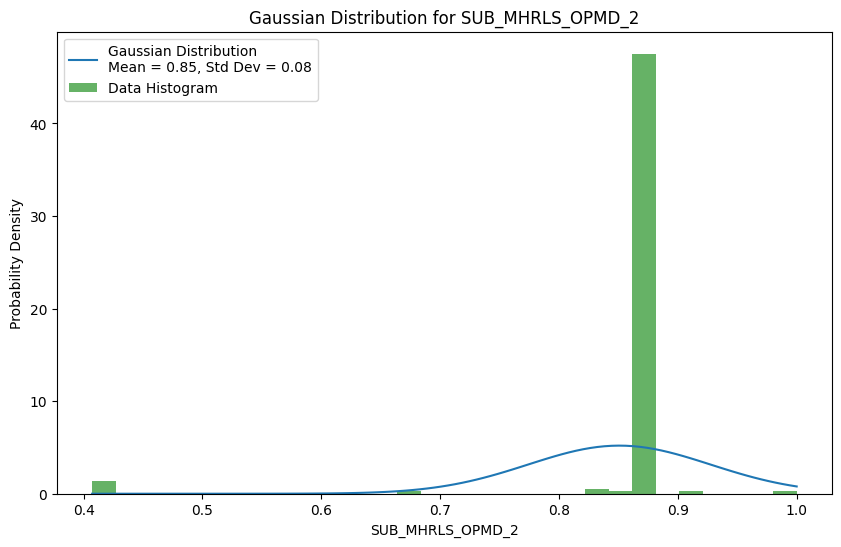

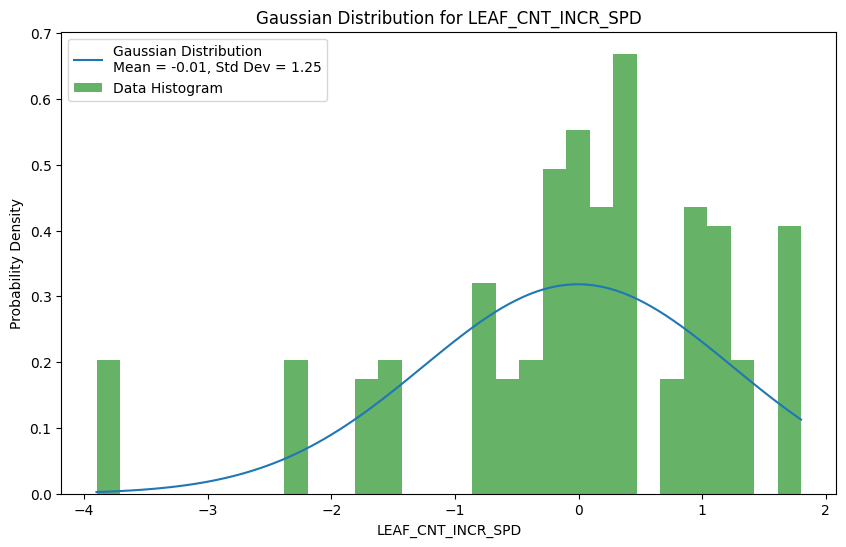

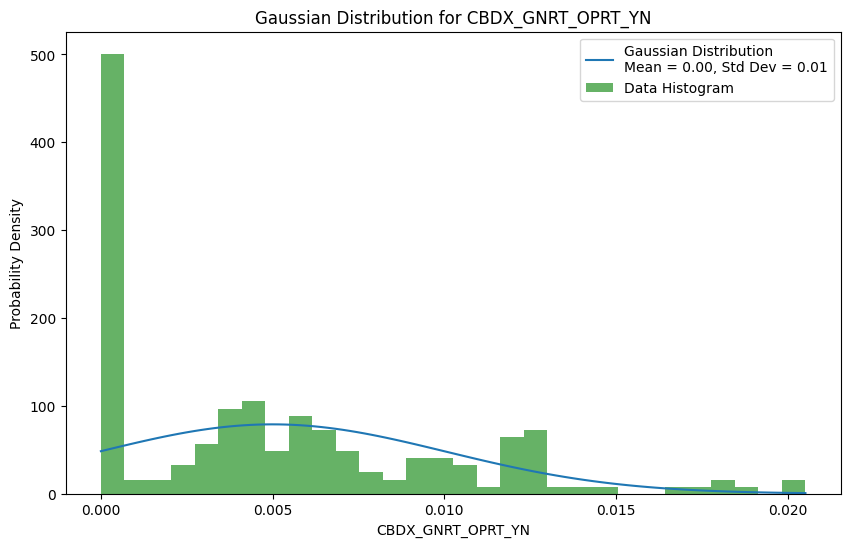

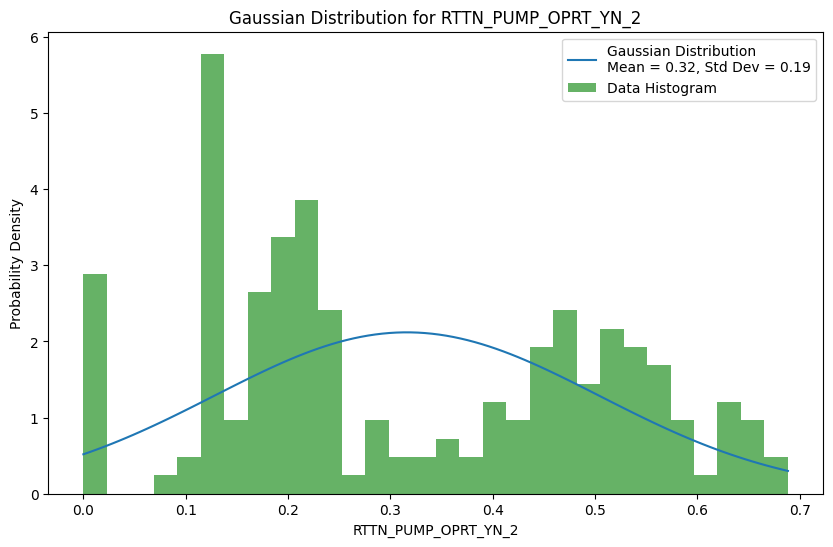

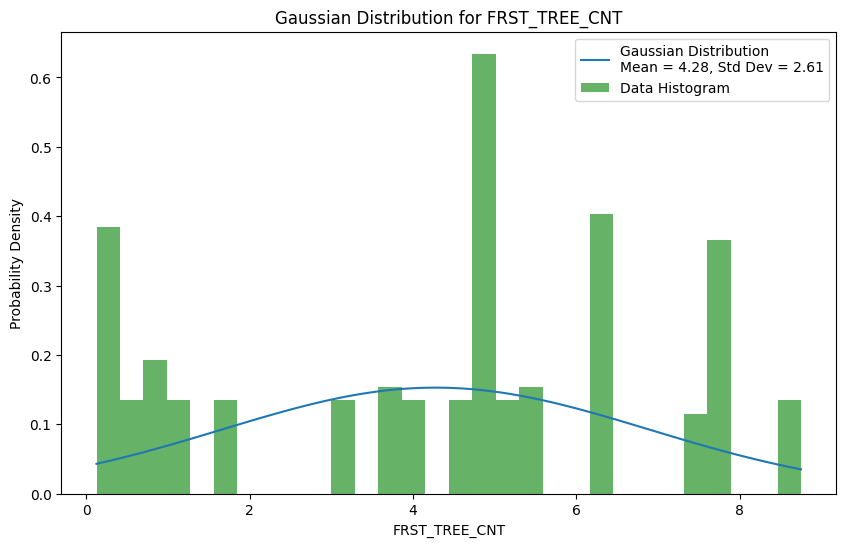

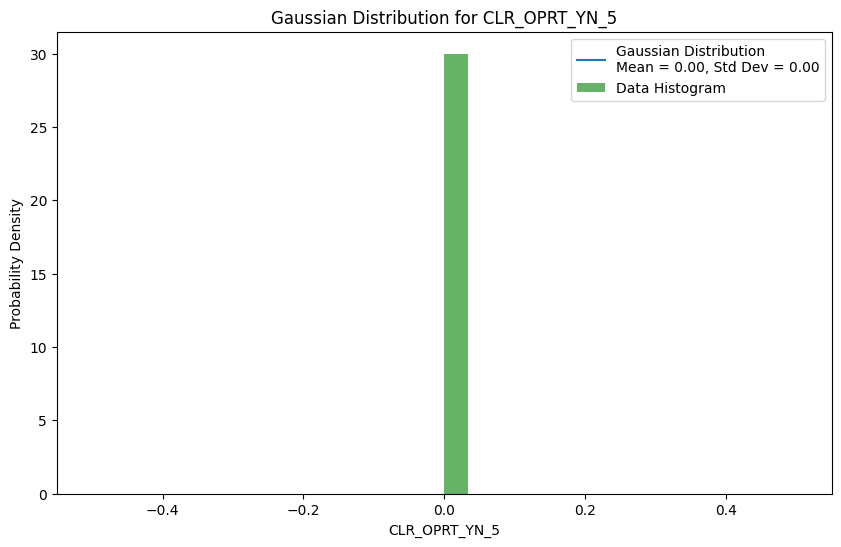

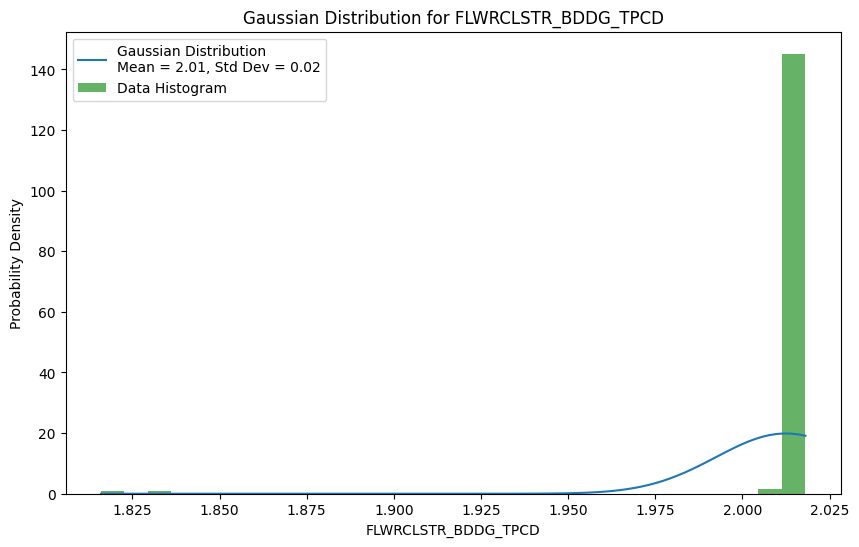

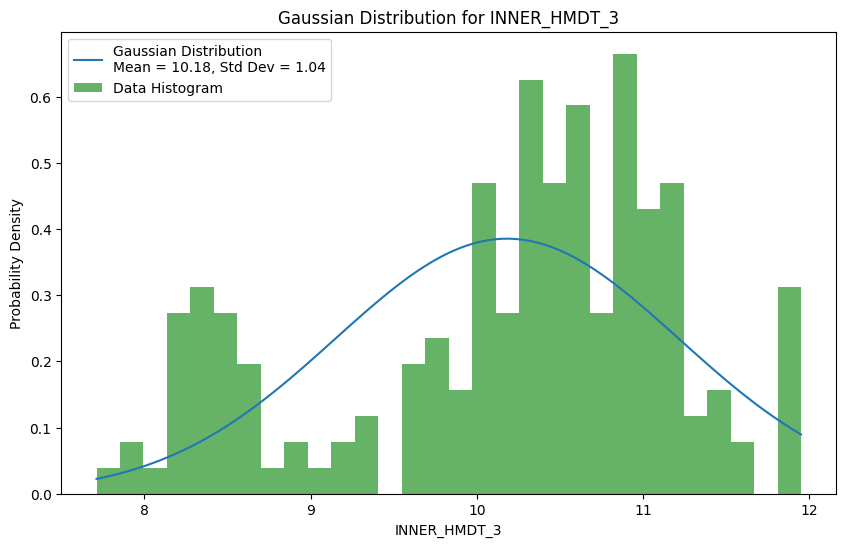

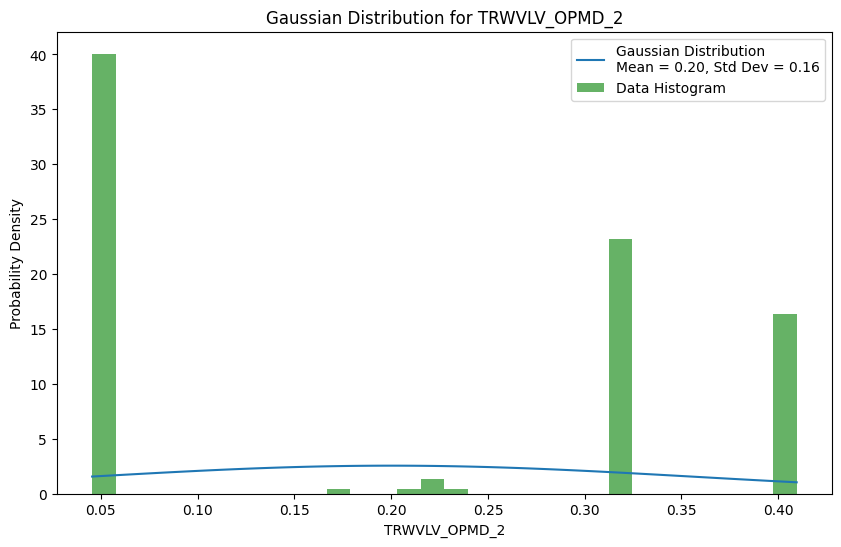

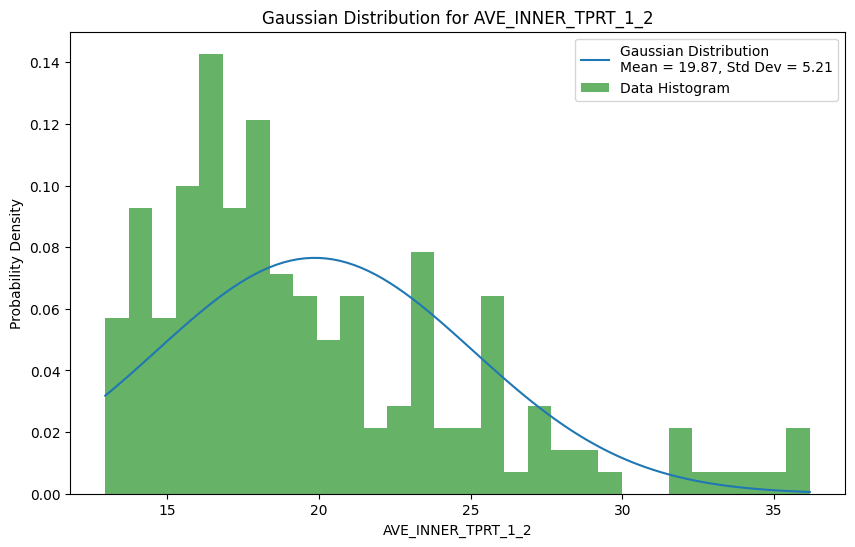

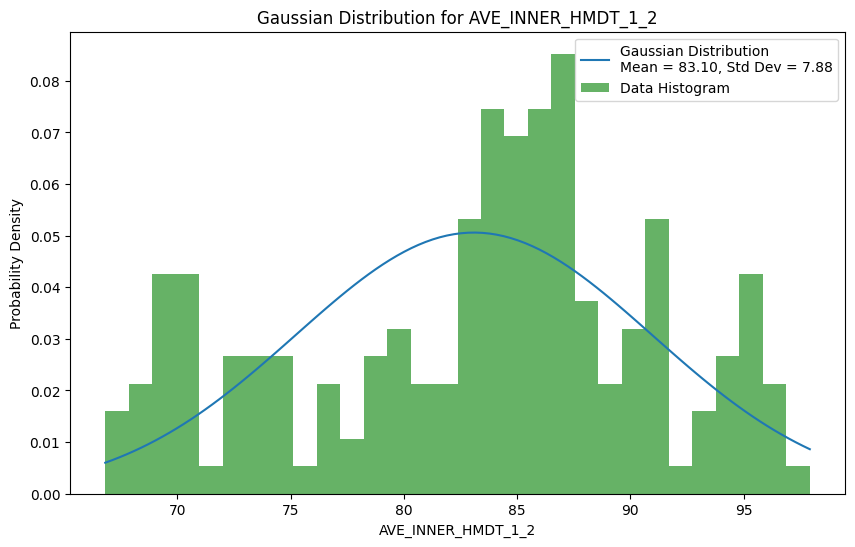

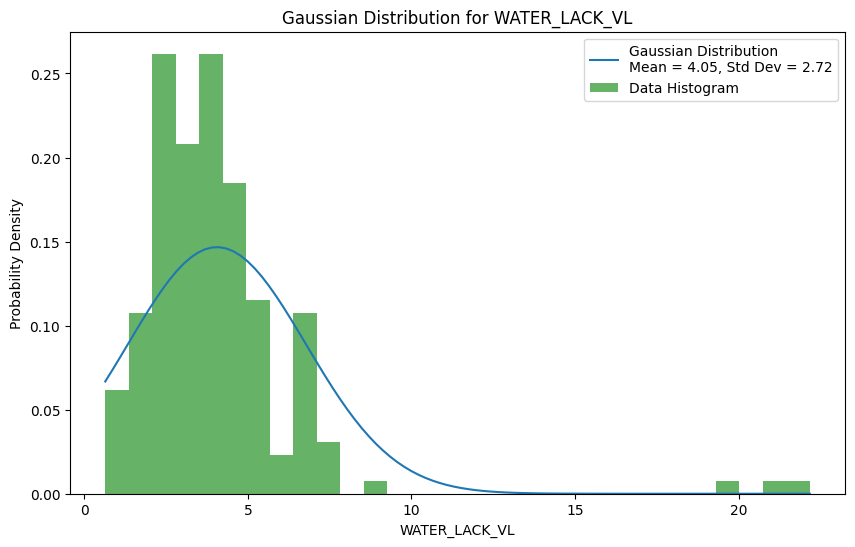

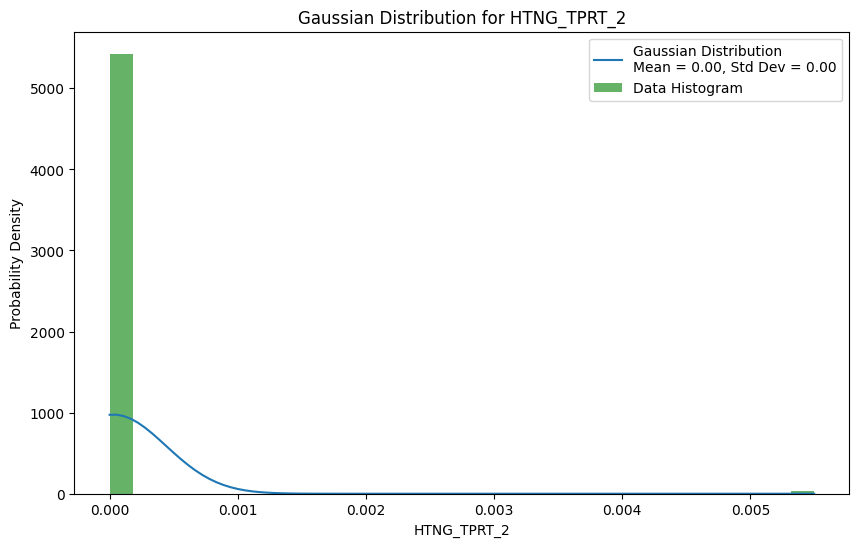

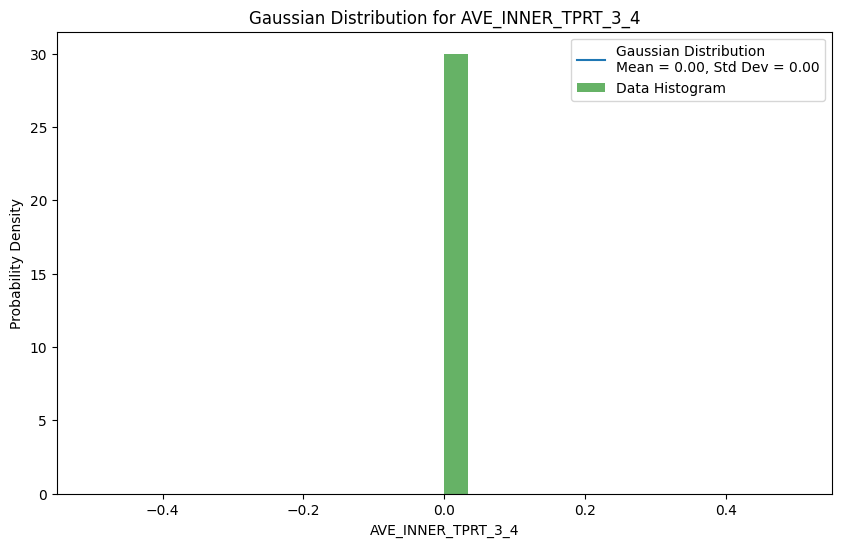

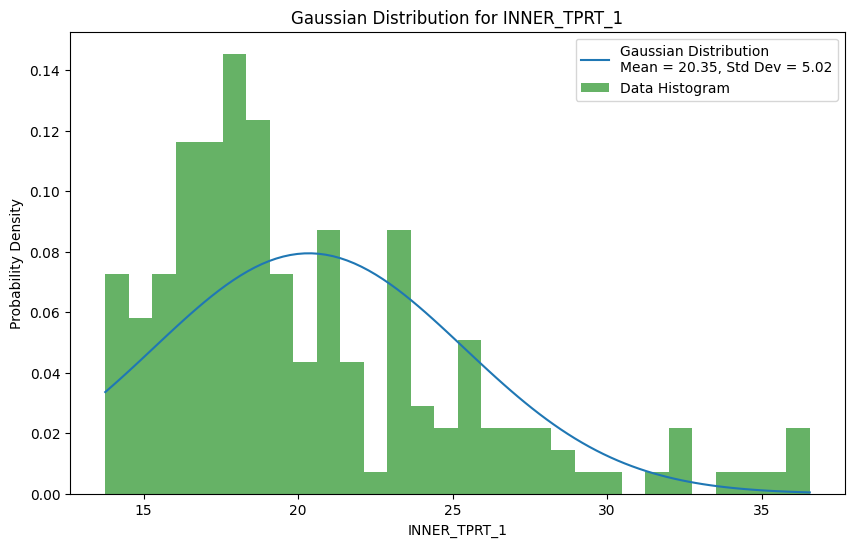

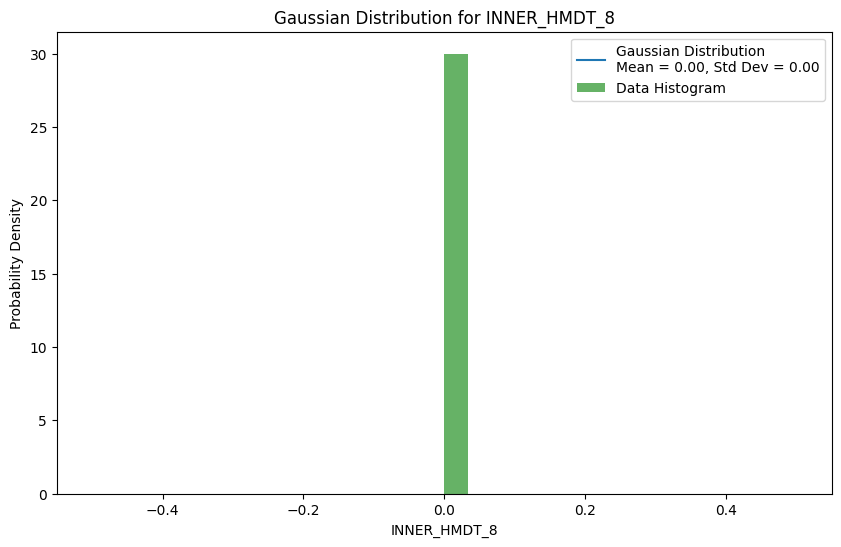

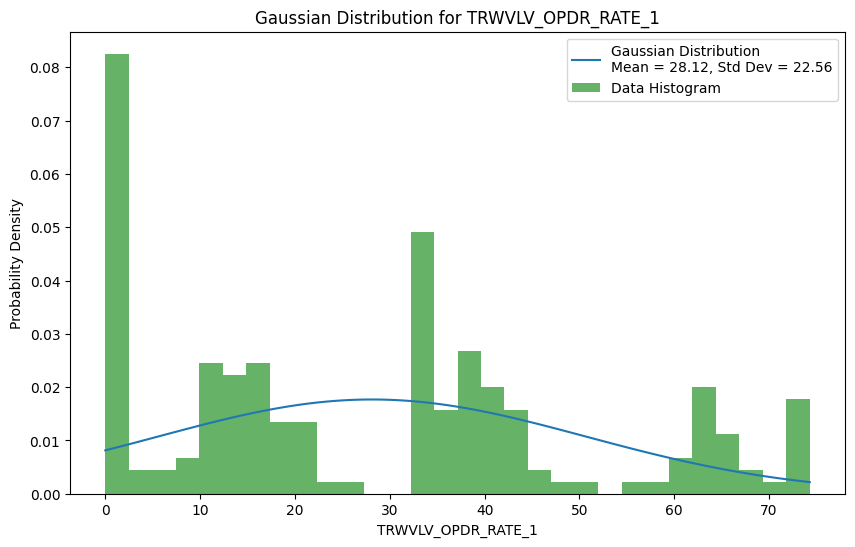

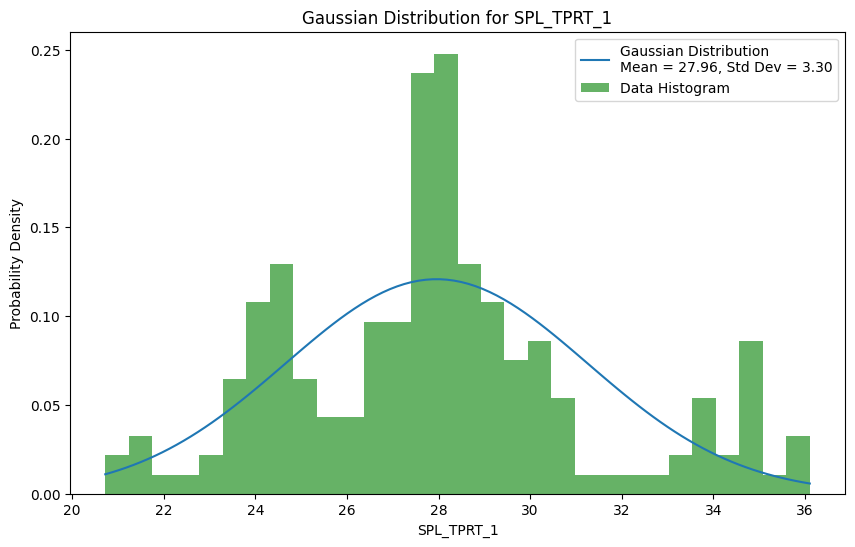

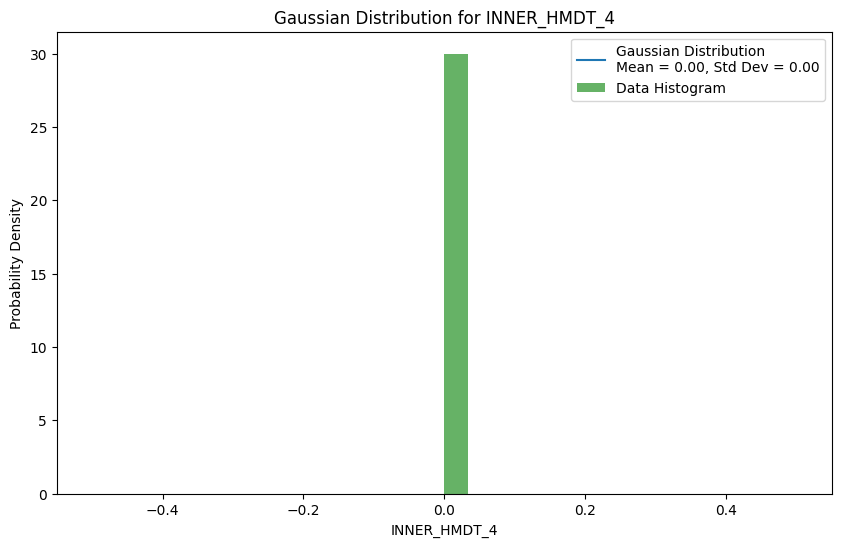

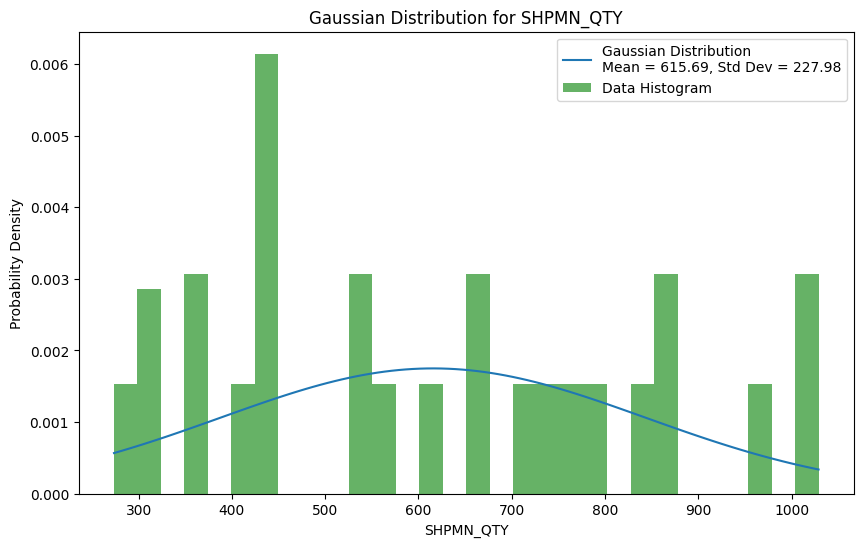

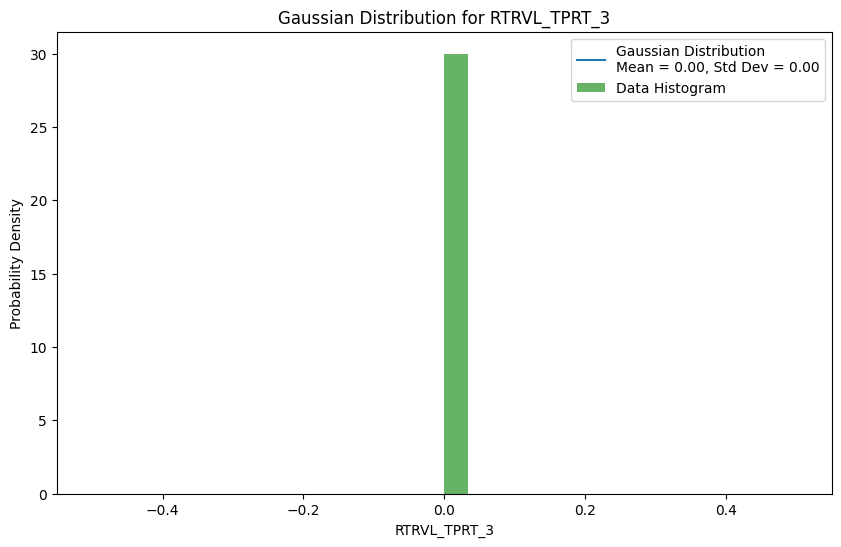

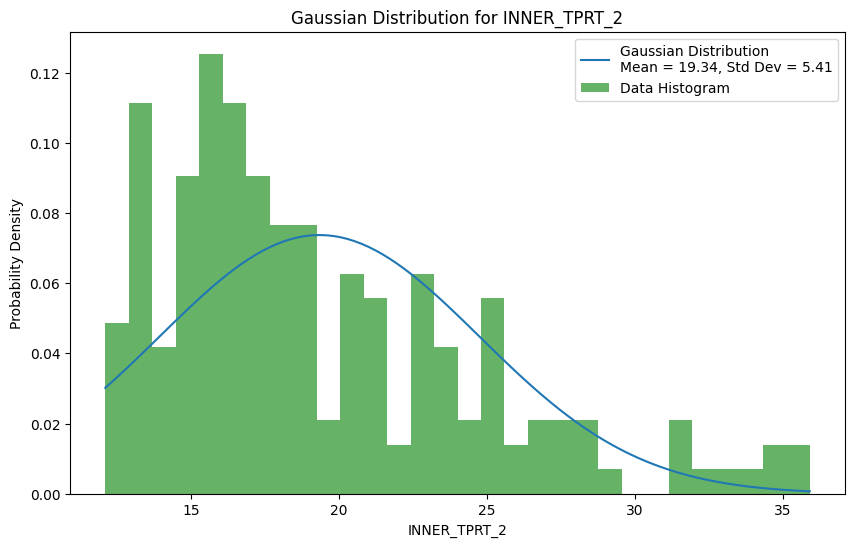

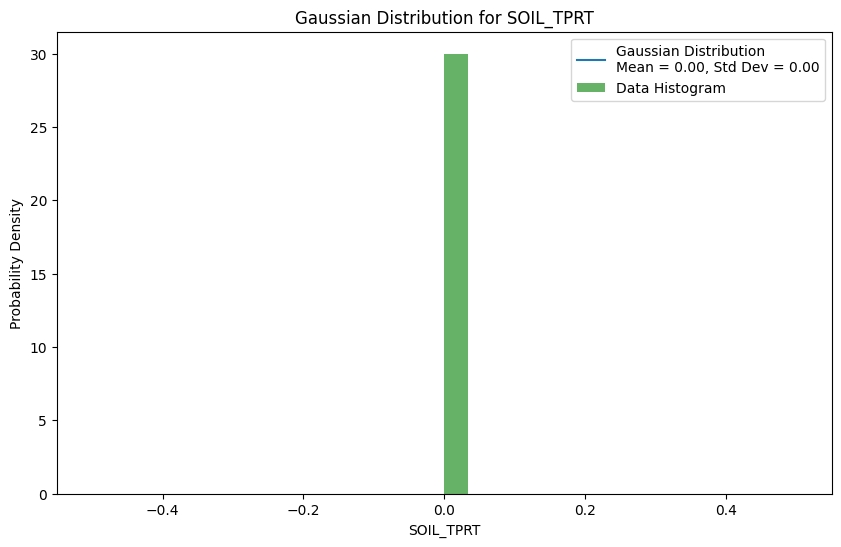

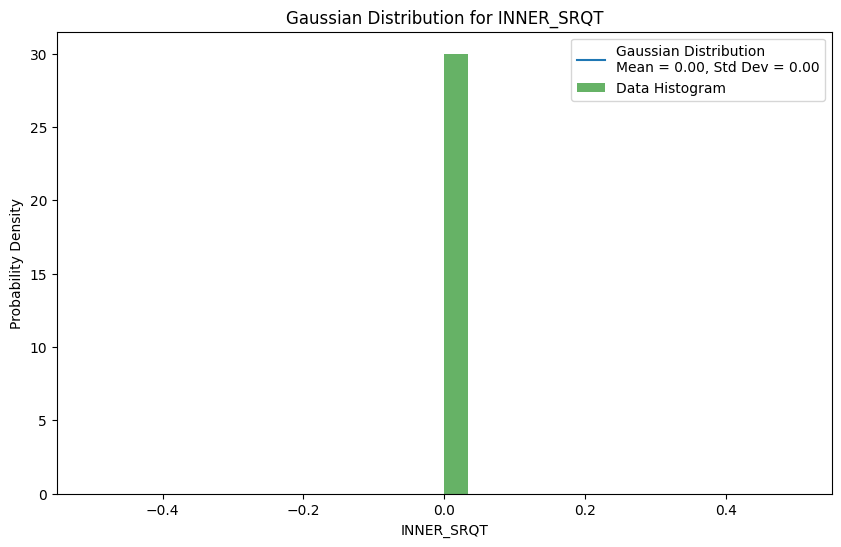

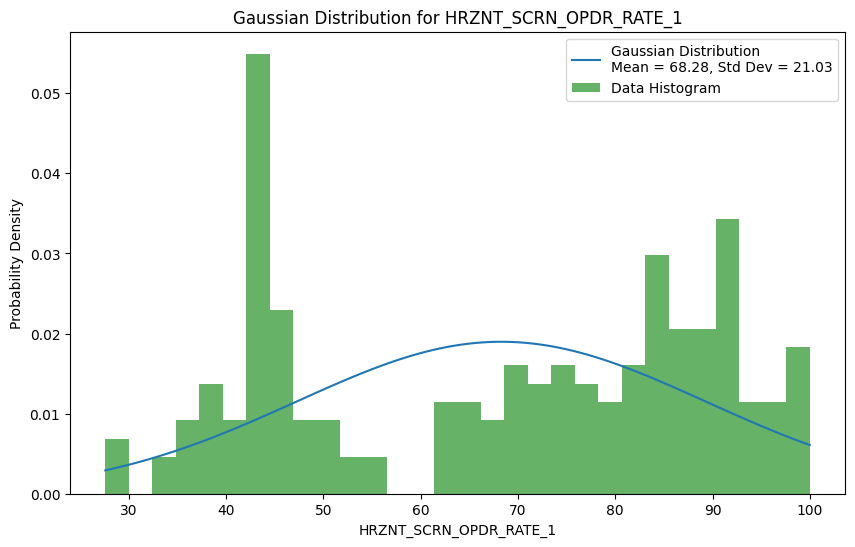

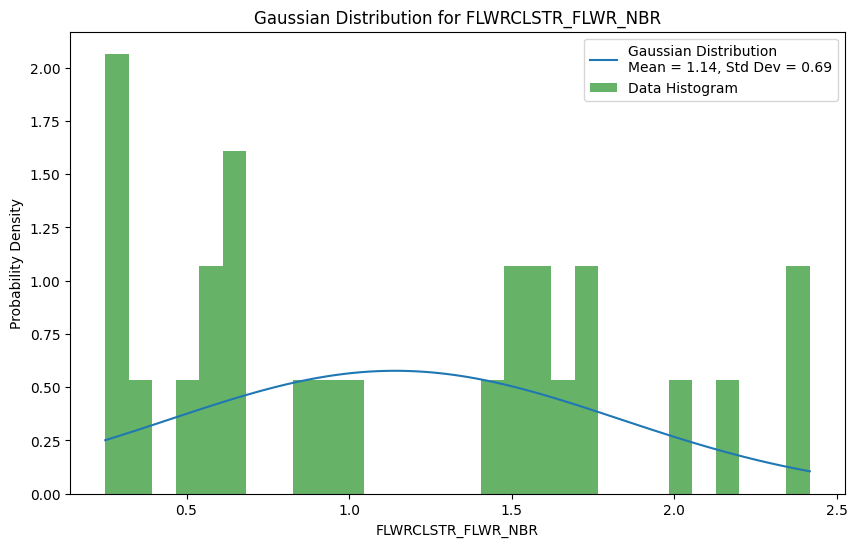

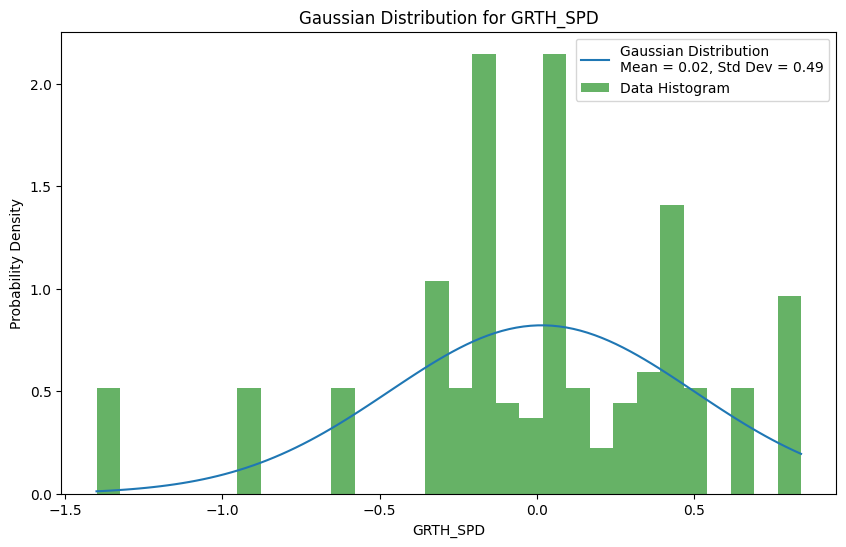

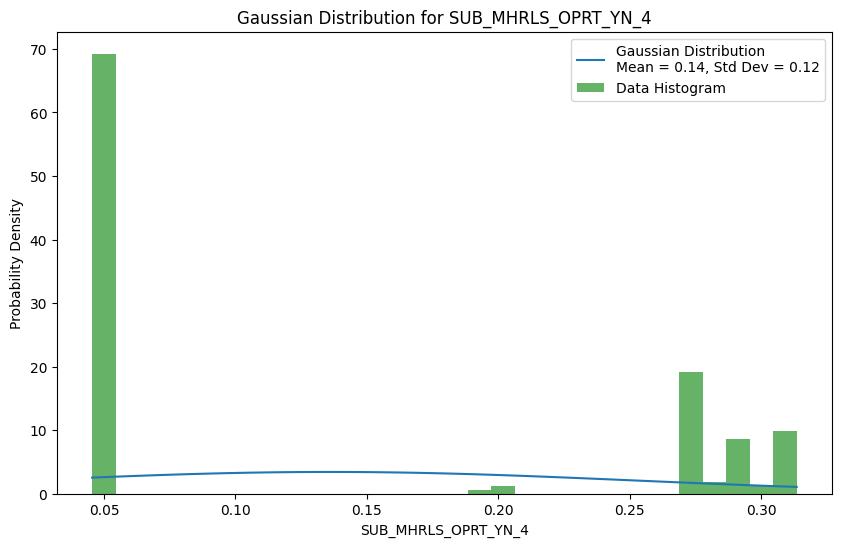

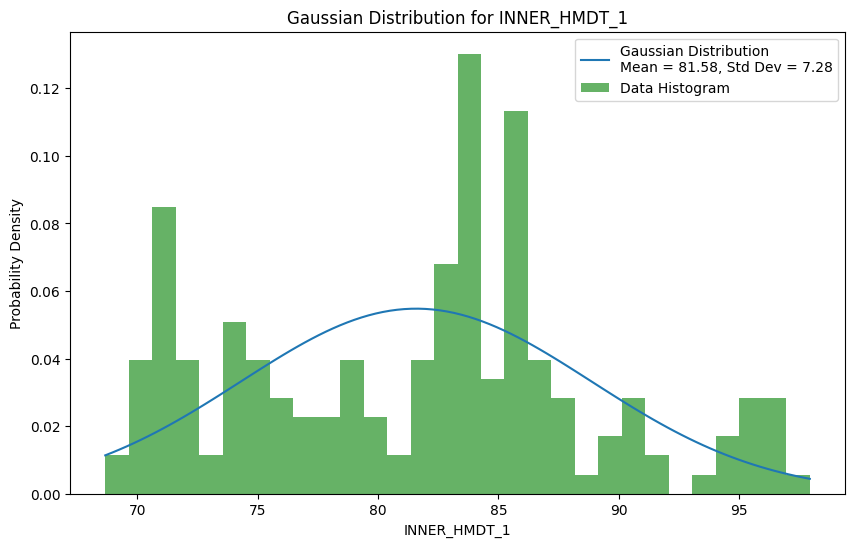

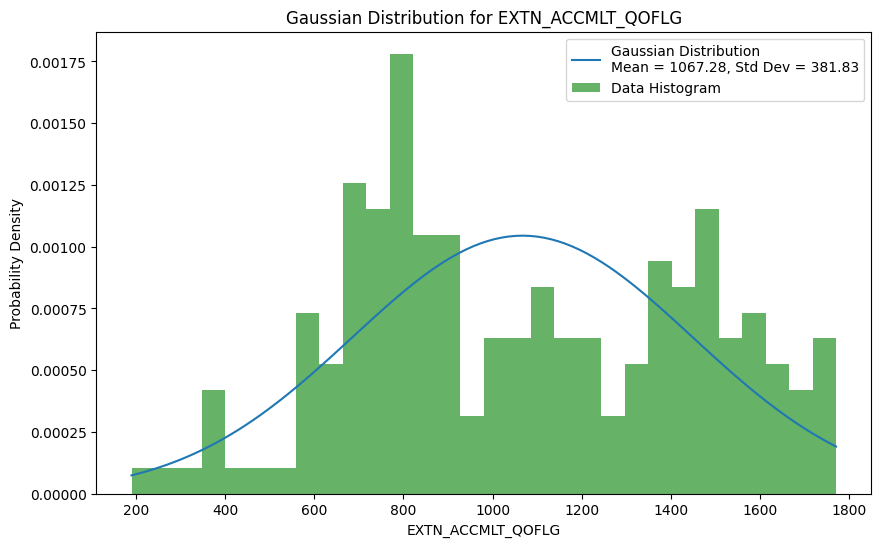

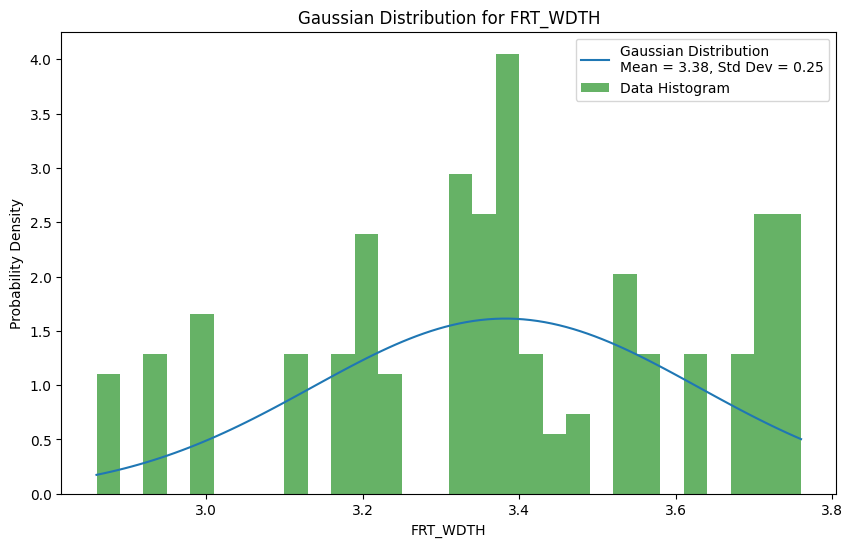

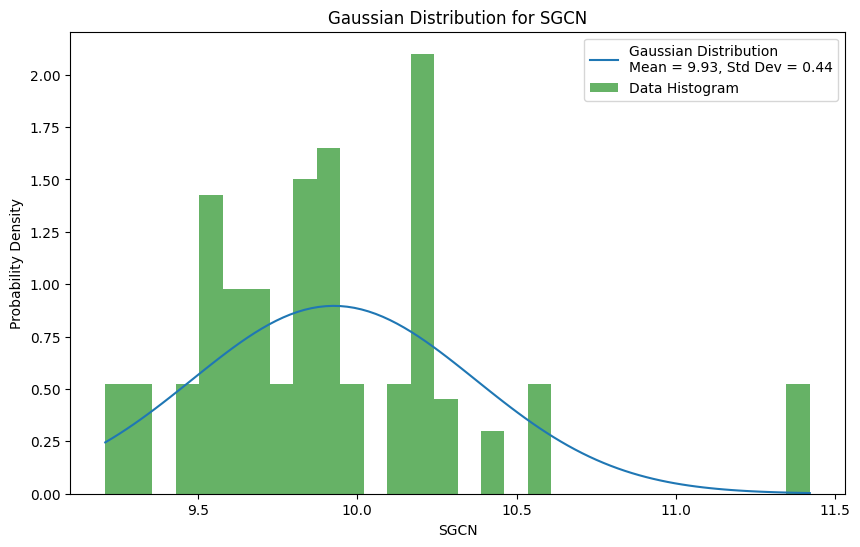

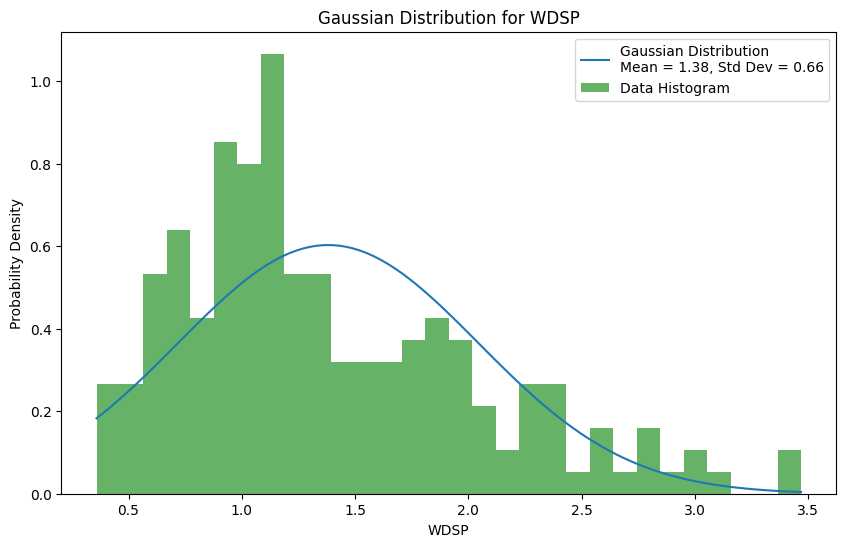

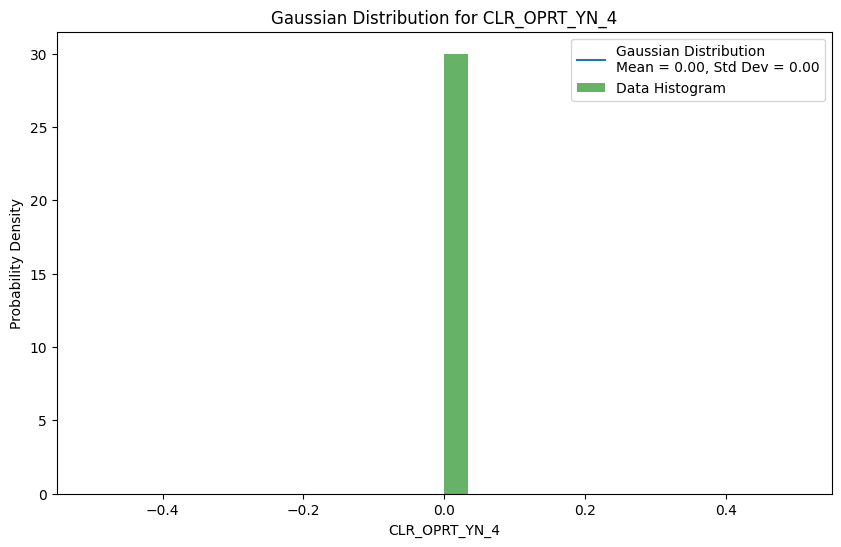

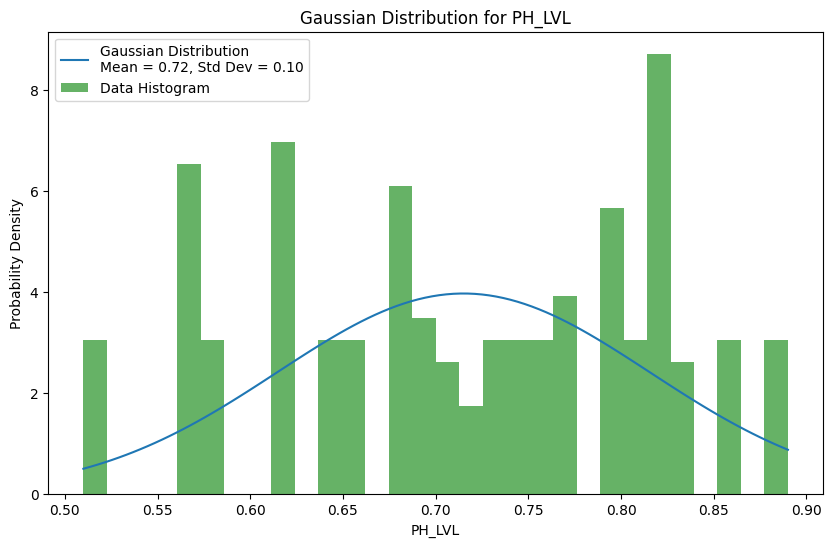

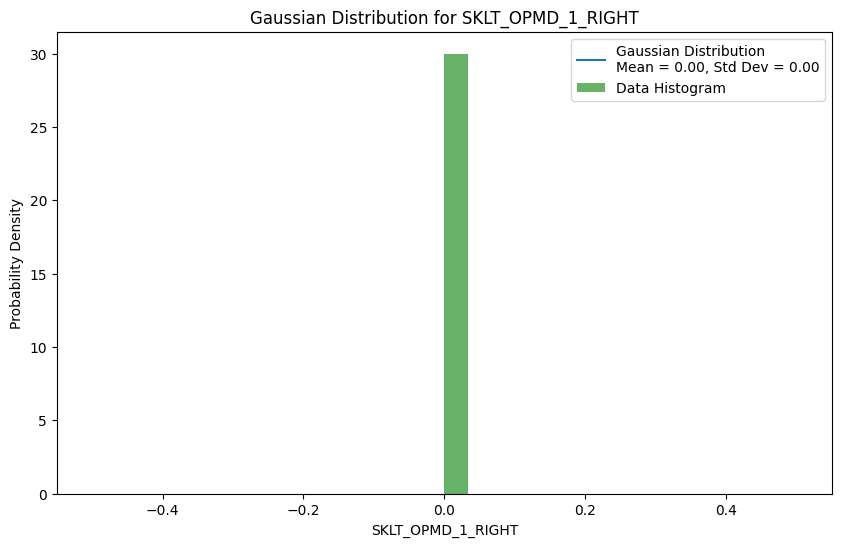

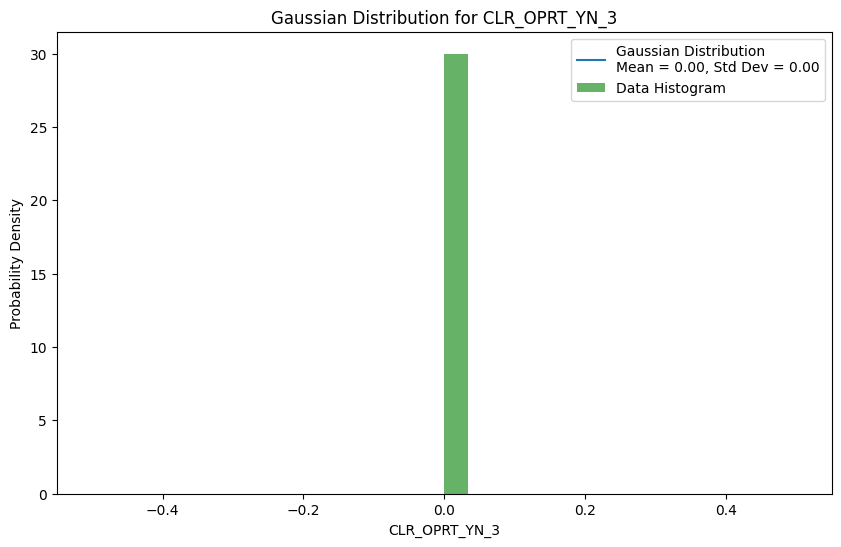

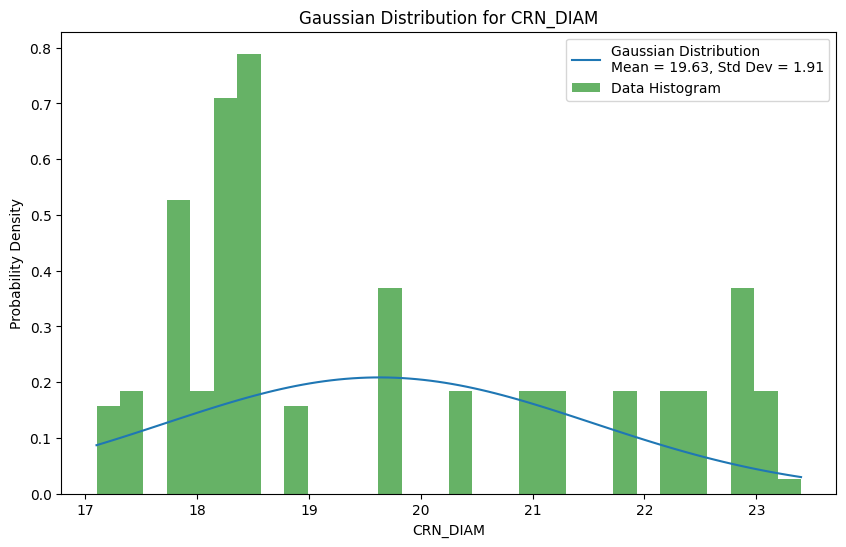

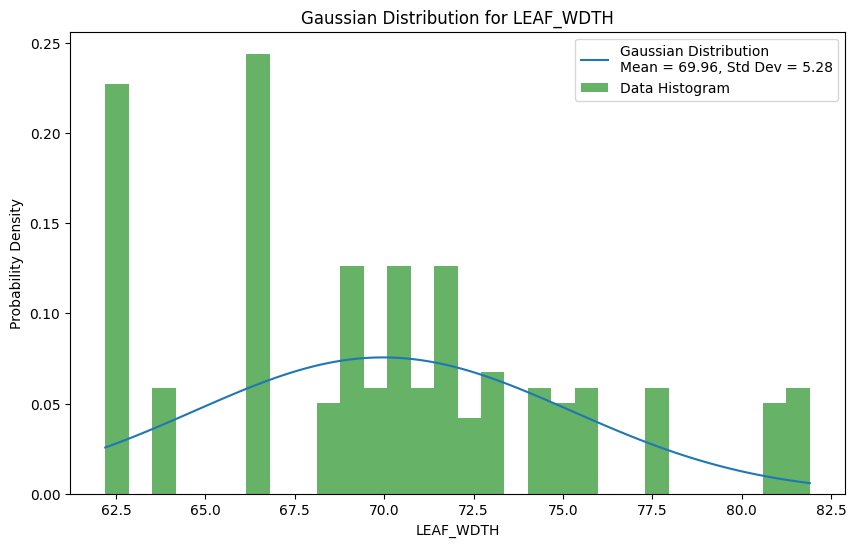

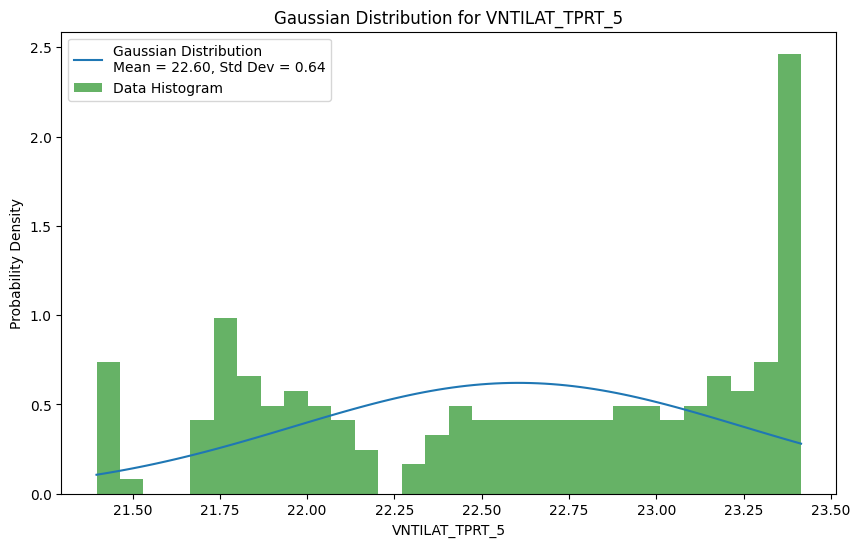

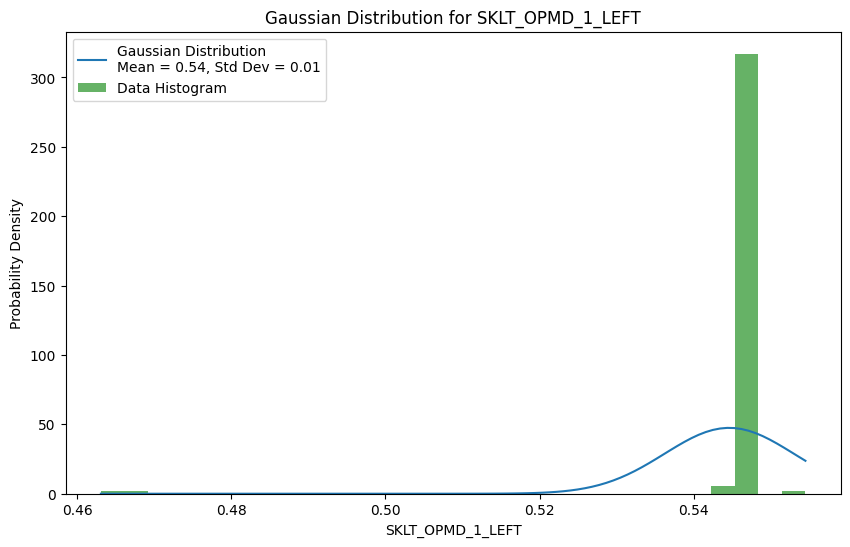

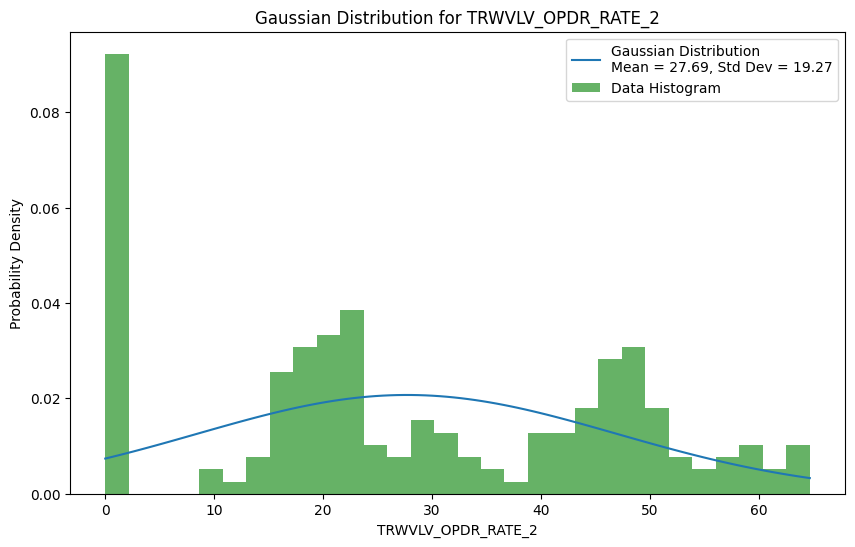

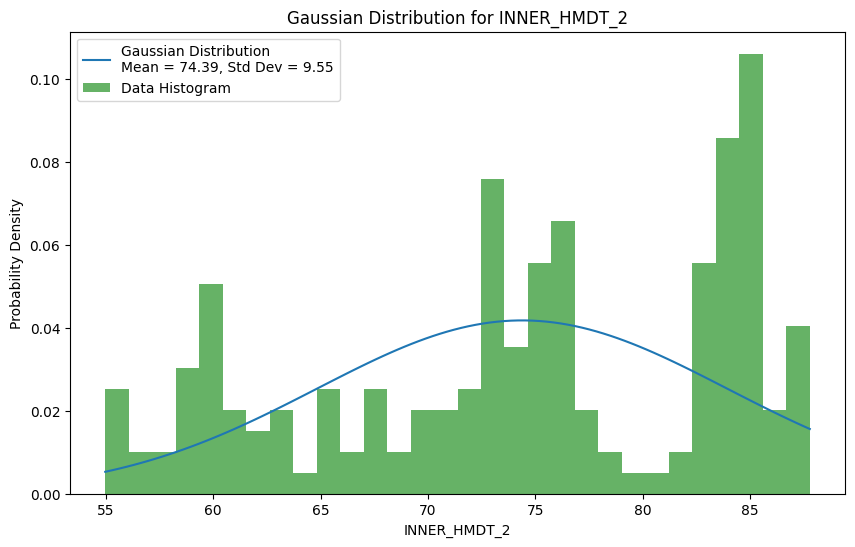

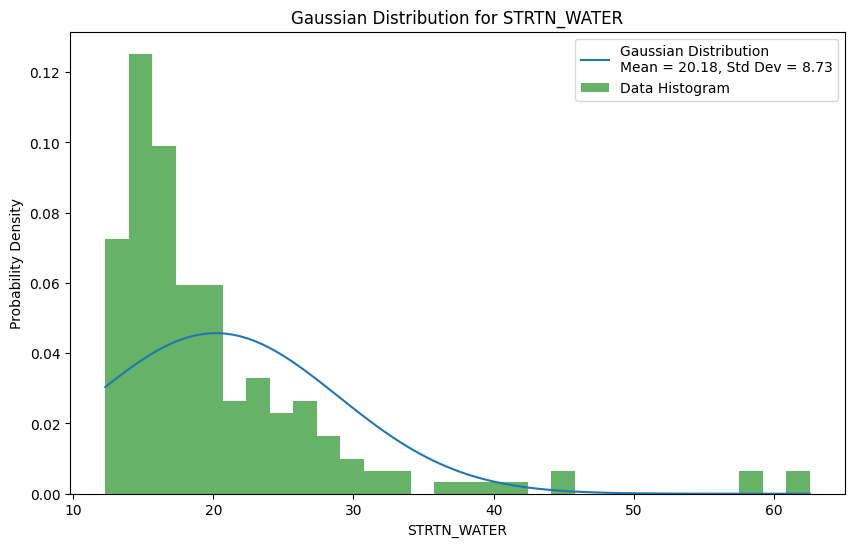

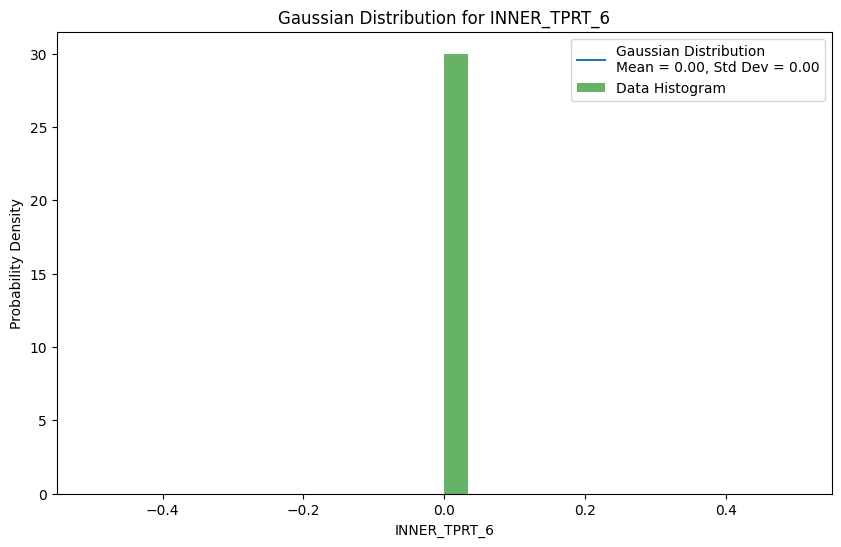

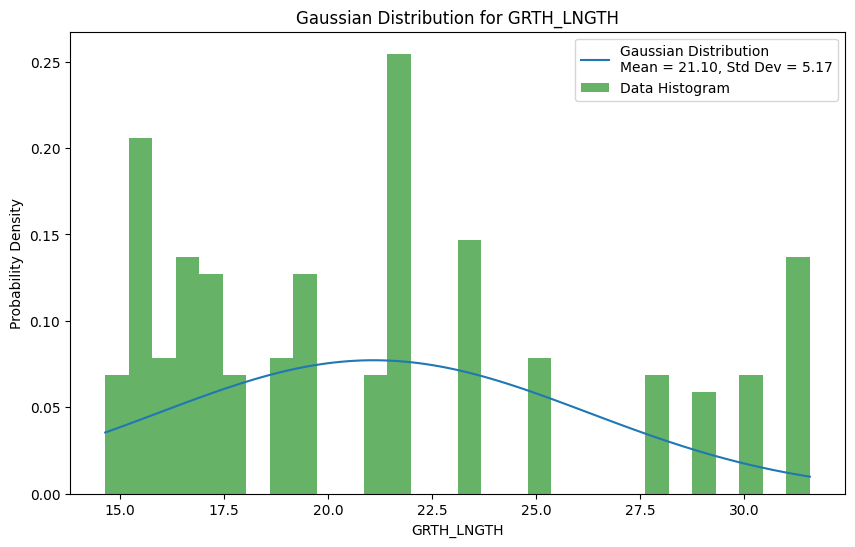

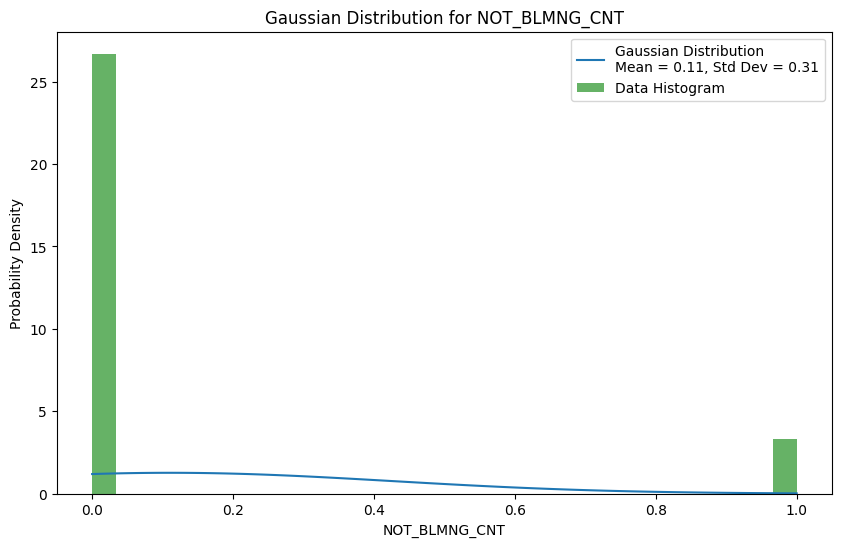

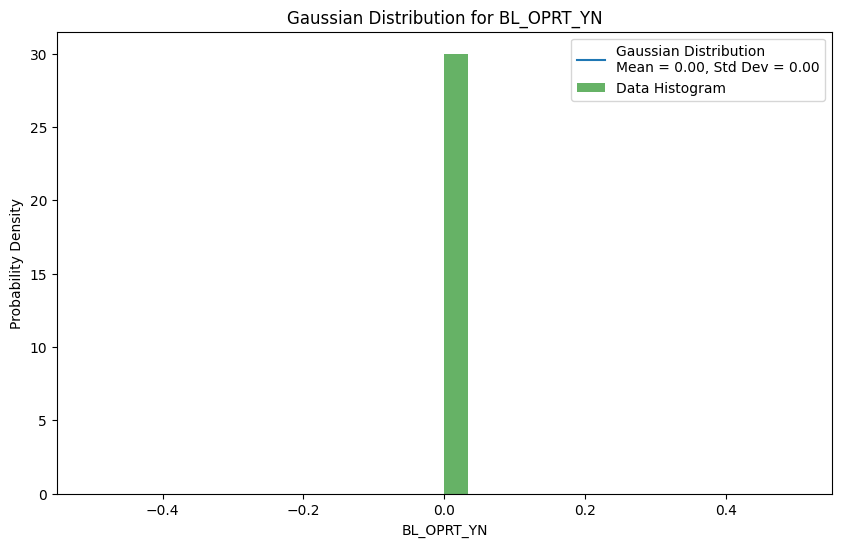

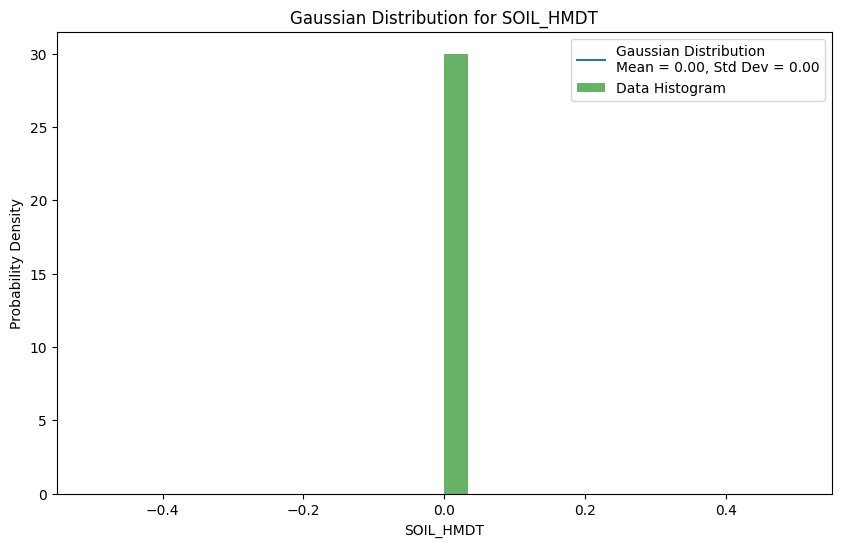

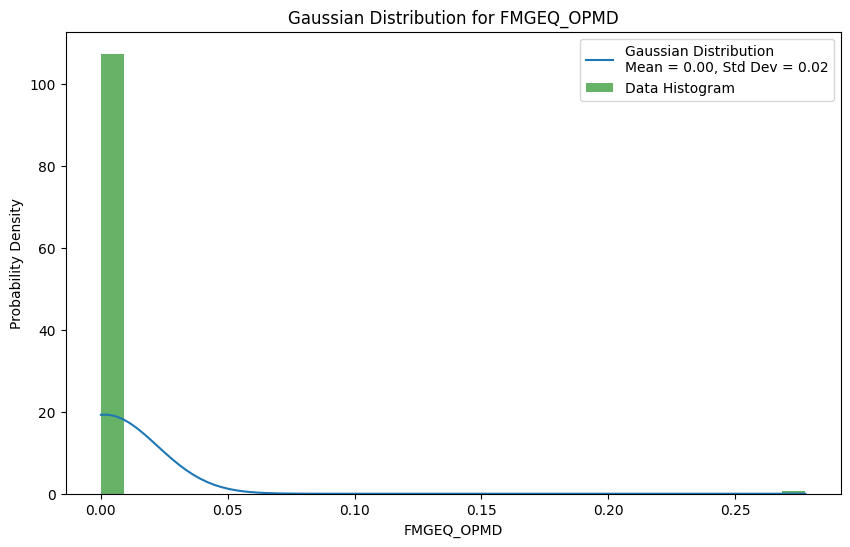

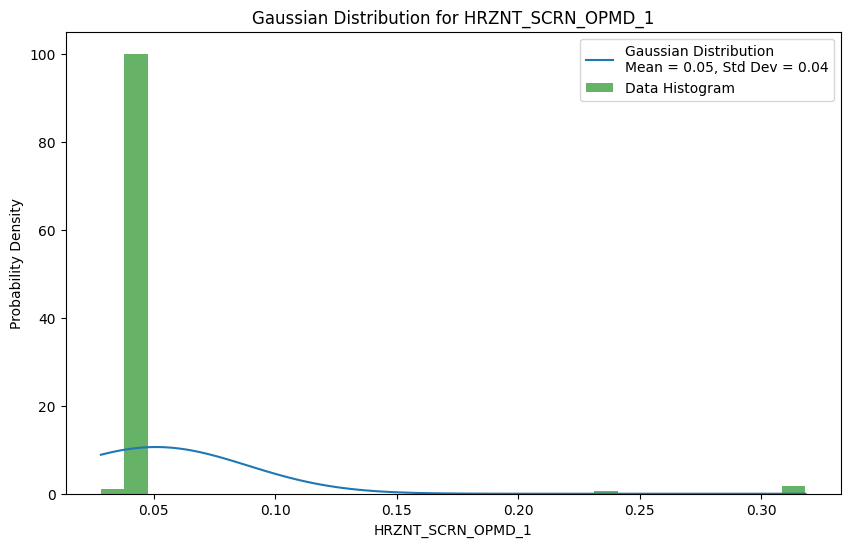

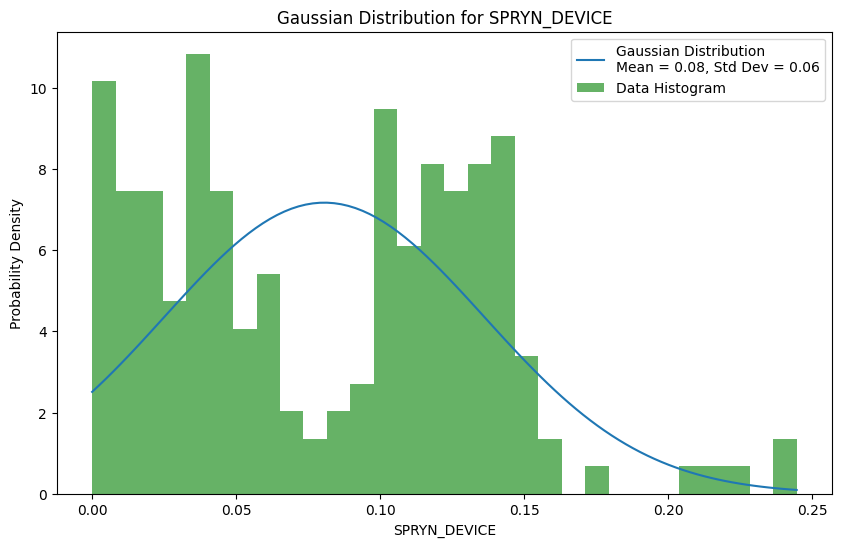

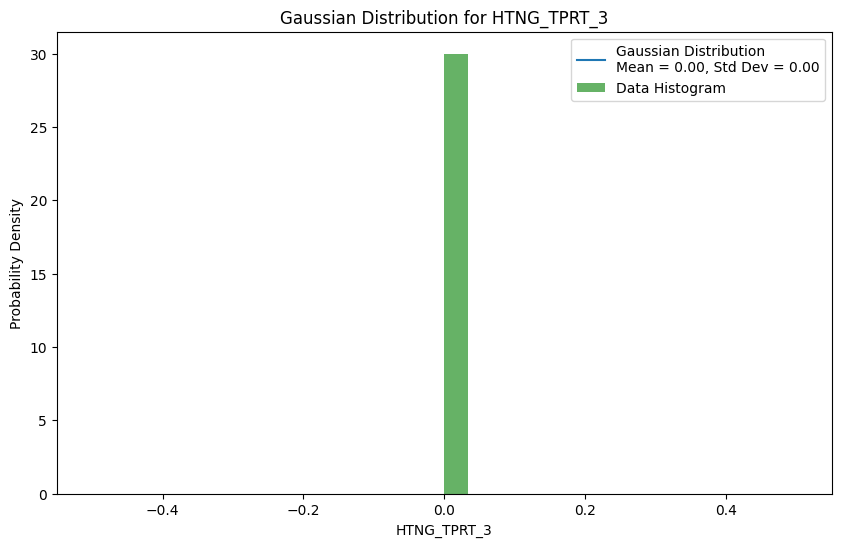

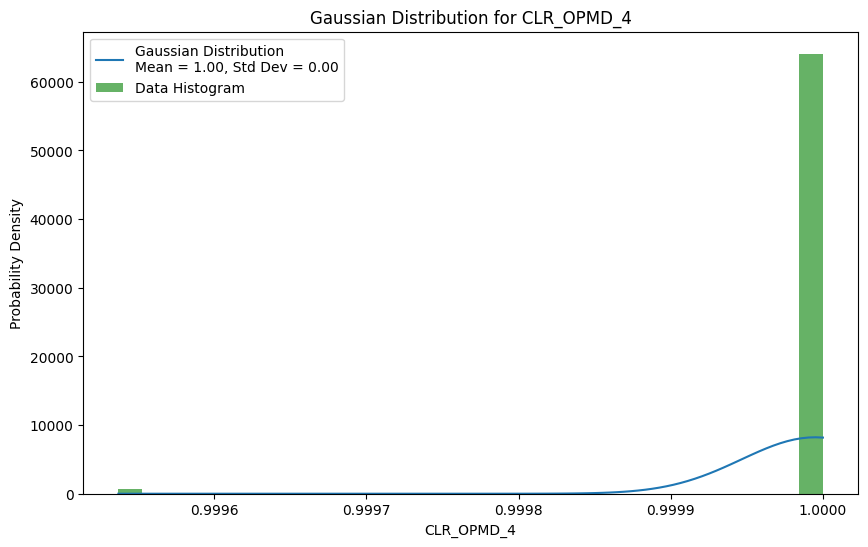

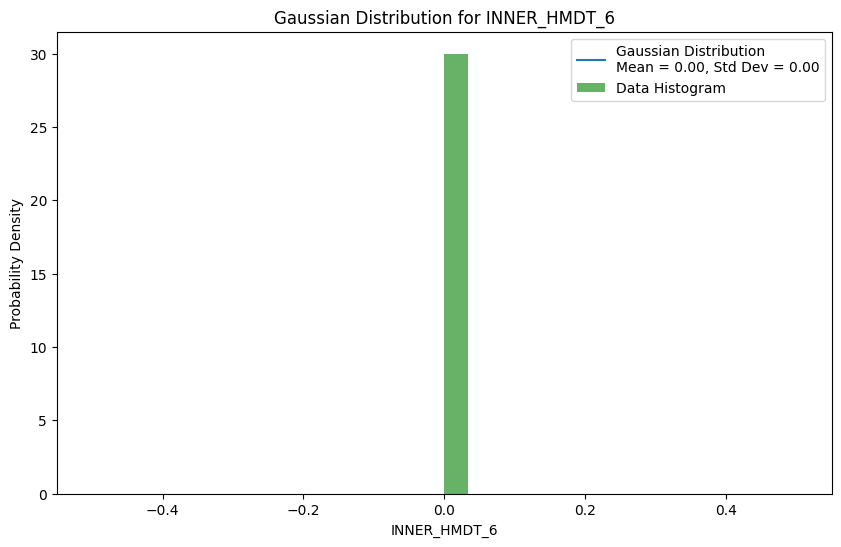

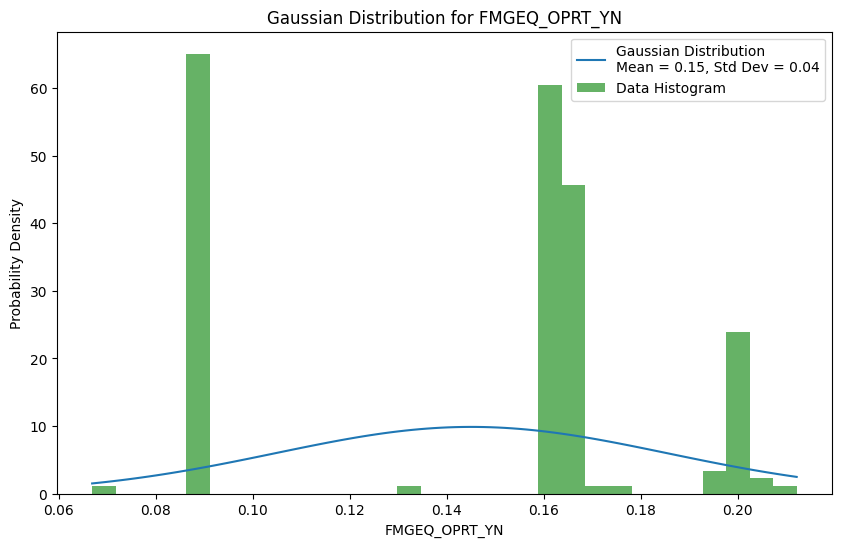

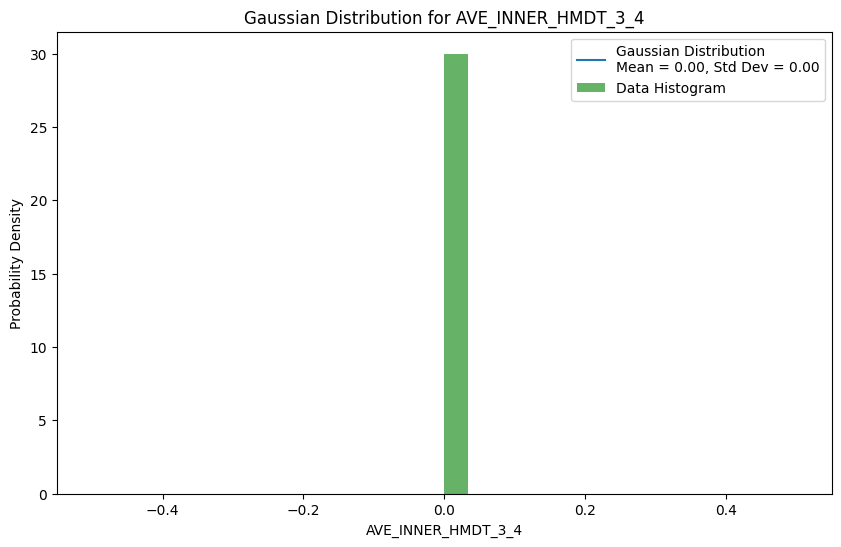

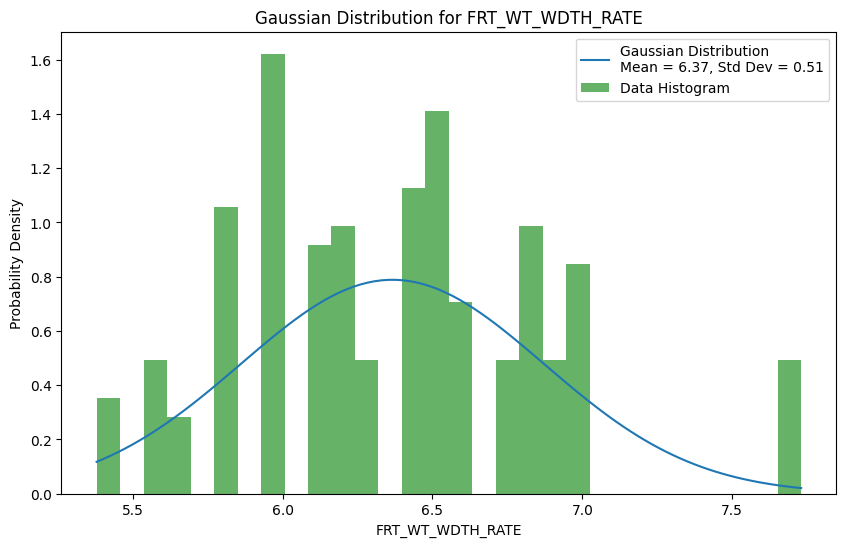

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 가우시안 분포를 시각화할 열 목록
columns = pdf.columns[1:]  # 첫 번째 열이 날짜이므로 제외

# 가우시안 분포 시각화
for column in columns:
    mean = means[column]
    std_dev = std_devs[column]
    
    # 데이터 범위 설정
    min_val = pdf[column].min()
    max_val = pdf[column].max()
    x = np.linspace(min_val, max_val, 100)
    
    # 가우시안 분포 계산
    y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
    
    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f'Gaussian Distribution\nMean = {mean:.2f}, Std Dev = {std_dev:.2f}')
    plt.hist(pdf[column], bins=30, density=True, alpha=0.6, color='g', label='Data Histogram')
    plt.title(f'Gaussian Distribution for {column}')
    plt.xlabel(column)
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os

# images/tomato 폴더 생성
output_dir = 'images/strawberry'
os.makedirs(output_dir, exist_ok=True)

# 가우시안 분포를 시각화할 열 목록
columns = pdf.columns[1:]  # 첫 번째 열이 날짜이므로 제외

# 가우시안 분포 시각화 및 파일 저장
for column in columns:
    mean = means[column]
    std_dev = std_devs[column]
    
    # 데이터 범위 설정
    min_val = pdf[column].min()
    max_val = pdf[column].max()
    x = np.linspace(min_val, max_val, 100)
    
    # 가우시안 분포 계산
    y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
    
    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f'Gaussian Distribution\nMean = {mean:.2f}, Std Dev = {std_dev:.2f}')
    plt.hist(pdf[column], bins=30, density=True, alpha=0.6, color='g', label='Data Histogram')
    plt.title(f'Gaussian Distribution for {column}')
    plt.xlabel(column)
    plt.ylabel('Probability Density')
    plt.legend()
    
    # 그래프를 파일로 저장
    filename = os.path.join(output_dir, f'gaussian_distribution_{column}.png')  # 또는 'jpg' 확장자를 사용
    plt.savefig(filename, format='png')  # format='jpg'로 변경 가능
    
    plt.close()  # 그래프를 닫아서 메모리 해제


/home/hadoop/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/home/hadoop/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
